In [256]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from textwrap import wrap
from math import sqrt
from enum import Enum
import json
from copy import deepcopy

from statistics import mean, stdev

# Colors and styles should be consistent!

bgpsec_color = 'C1' # purple
bgpisec_color = 'C2' # green
path_end_color = 'C0' # blue
#baseline_color = 'C7' # grey
baseline_color = 'C0' # black

bgpsec_style = 'dashed'
default_style = 'solid'
path_end_style = 'dotted'

default_marker = ''
overhead_marker = 'P'
aggressive_marker = '*'
timid_marker = '.'
baseline_marker = ''


linemap = {
    'BGP': {'color': baseline_color, 'marker': baseline_marker, 'linestyle': default_style},
    'No path defense': {'color': baseline_color, 'marker': baseline_marker, 'linestyle': default_style},
    'BGP+100% ROV': {'color': baseline_color, 'marker': '', 'linestyle': default_style},
    'BGP-iSec Encrypted UP, Aggressive': {'color': 'C7', 'marker': aggressive_marker, 'linestyle': 'dashed'},
    'BGP-iSec Encrypted UP, Aggressive': {'color': 'C7', 'marker': aggressive_marker, 'linestyle': 'dashed'},
    'BGP-iSec Encrypted UP, Eavesdropper': {'color': 'C7', 'marker': timid_marker, 'linestyle': 'dashed'},
    'BGP-iSec Encrypted UP, SP-EA Eavesdropper': {'color': 'C7', 'marker': timid_marker, 'linestyle': ''},
    'BGP-iSec No Encrypted UP, Eavesdropper': {'color': 'C8', 'marker': timid_marker, 'linestyle': 'dotted'},
    'BGP-iSec No Encrypted UP, No Eavesdropping': {'color': bgpisec_color, 'marker': timid_marker, 'linestyle': 'solid'},
    'BGP-iSec No Encrypted UP, SP-EA Eavesdropper': {'color': 'C8', 'marker': timid_marker, 'linestyle': 'dotted'},
    'BGP-iSec No Encrypted UP, SP-EA No Eavesdropping': {'color': bgpisec_color, 'marker': timid_marker, 'linestyle': 'solid'},
    'BGP-iSec Trans, SP-EA': {'color': 'C8', 'marker': timid_marker, 'linestyle': 'dashed'},
    'BGP-iSec Trans-DO, SP-EA': {'color': 'C7', 'marker': timid_marker, 'linestyle': 'dashed'},
    'BGP-iSec Trans-Only': {'color': 'C8', 'marker': timid_marker, 'linestyle': 'dotted'},
    'BGP-iSec Transitive-Only, Aggressive': {'color': 'C8', 'marker': aggressive_marker, 'linestyle': 'dotted'},
    'BGP-iSec Transitive-Only, Connector': {'color': 'C8', 'marker': '', 'linestyle': 'dotted'},
    'BGP-iSec Transitive-Only, Timid': {'color': 'C8', 'marker': timid_marker, 'linestyle': 'dotted'},
    'BGP-iSec Transitive-Only, SP-EA': {'color': 'C8', 'marker': timid_marker, 'linestyle': 'dotted'},
    'BGP-iSec with Path Shortening Defense': {'color': 'C7', 'marker': timid_marker, 'linestyle': 'dotted'},
    'BGP-iSec with Path Shortening Defense, Aggressive': {'color': 'C7', 'marker': aggressive_marker, 'linestyle': 'dotted'},
    'BGP-iSec with Path Shortening Defense, Connector': {'color': 'C7', 'marker': '', 'linestyle': 'dotted'},
    'BGP-iSec with Path Shortening Defense, Timid': {'color': 'C7', 'marker': timid_marker, 'linestyle': 'dotted'},
    'BGP-iSec': {'color': bgpisec_color, 'marker': timid_marker, 'linestyle': default_style},
    'BGP-iSec+100% ROV': {'color': bgpisec_color, 'marker': timid_marker, 'linestyle': default_style},
    'BGP-iSec+100% ROV, Aggressive': {'color': bgpisec_color, 'marker': aggressive_marker, 'linestyle': default_style},
    'BGP-iSec+100% ROV, Connector': {'color': bgpisec_color, 'marker': '', 'linestyle': default_style},
    'BGP-iSec+100% ROV, Shortest-Path Export-All': {'color': bgpisec_color, 'marker': timid_marker, 'linestyle': default_style},
    'BGP-iSec+100% ROV, Timid': {'color': bgpisec_color, 'marker': timid_marker, 'linestyle': default_style},
    'BGP-iSec, Aggressive': {'color': bgpisec_color, 'marker': aggressive_marker, 'linestyle': default_style},
    'BGP-iSec, Aggressive Full Attacker': {'color': bgpisec_color, 'marker': aggressive_marker, 'linestyle': default_style},
    'BGP-iSec-UP, Aggressive': {'color': 'C7', 'marker': aggressive_marker, 'linestyle': default_style},
    'BGP-iSec, Aggressive (Adopting)': {'color': bgpisec_color, 'marker': aggressive_marker, 'linestyle': default_style},
    'BGP-iSec, SP-EA (Adopting)': {'color': bgpisec_color, 'marker': timid_marker, 'linestyle': default_style},
    'BGP-iSec, Aggressive (Non-Adopting)': {'color': 'C0', 'marker': aggressive_marker, 'linestyle': 'dotted'},
    'BGP-iSec, SP-EA (Non-Adopting)': {'color': 'C0', 'marker': timid_marker, 'linestyle': 'dotted'},
    'BGP-iSec, Connector': {'color': bgpisec_color, 'marker': '', 'linestyle': default_style},
    'BGP-iSec-UP, Full Attacker': {'color': 'C7', 'marker': timid_marker, 'linestyle': 'dotted'},
    'BGP-iSec-UP': {'color': 'C7', 'marker': timid_marker, 'linestyle': 'dotted'},
    'BGP-iSec-Trans-OTC-Only and BGP-iSec-UP': {'color': 'C7', 'marker': timid_marker, 'linestyle': 'solid'},
    'BGP-iSec, Full Attacker': {'color': bgpisec_color, 'marker': timid_marker, 'linestyle': default_style},
    'BGP-iSec, Full/Global Attacker': {'color': bgpisec_color, 'marker': timid_marker, 'linestyle': default_style},
    'BGP-iSec-UP, Global Attacker': {'color': 'C7', 'marker': timid_marker, 'linestyle': 'dotted'},
    'BGP-iSec, Overhead': {'color': bgpisec_color, 'marker': overhead_marker, 'linestyle': default_style},
    'BGP-iSec, SP-EA': {'color': bgpisec_color, 'marker': timid_marker, 'linestyle': 'dashed'},
    'BGP-iSec, Timid': {'color': bgpisec_color, 'marker': timid_marker, 'linestyle': default_style},
    'BGP-iSec, SP-EA': {'color': bgpisec_color, 'marker': timid_marker, 'linestyle': default_style},
    'BGP-iSec, Timid-All': {'color': 'C9', 'marker': timid_marker, 'linestyle': 'dotted'},
    'BGP-iSec-E-UP, Aggressive': {'color': 'C7', 'marker': aggressive_marker, 'linestyle': 'dashed'},
    'BGP-iSec-E-UP, Eavesdropper': {'color': 'C7', 'marker': timid_marker, 'linestyle': 'dashed'},
    'BGP-iSec-EUp, Aggressive': {'color': 'C7', 'marker': aggressive_marker, 'linestyle': 'dashed'},
    'BGP-iSec-Trans-OTC-Only': {'color': 'C4', 'marker': timid_marker, 'linestyle': 'solid'},
    'BGP-iSec-Trans-DO-Only, Aggressive': {'color': 'C4', 'marker': aggressive_marker, 'linestyle': 'solid'},
    'BGP-iSec-Trans-DO-Only, Connector': {'color': 'C4', 'marker': '', 'linestyle': 'solid'},
    'BGP-iSec-Trans-DO-Only, Timid': {'color': 'C4', 'marker': timid_marker, 'linestyle': 'solid'},
    'BGP-iSec-Trans-DO-Only, SP-EA': {'color': 'C4', 'marker': timid_marker, 'linestyle': 'solid'},
    'BGP-iSec-UP, Full Attacker': {'color': 'C7', 'marker': timid_marker, 'linestyle': 'dotted'},
    'BGPsec': {'color': bgpsec_color, 'marker': aggressive_marker, 'linestyle': bgpsec_style},
    'BGPsec+100% ROV': {'color': bgpsec_color, 'marker': aggressive_marker, 'linestyle': bgpsec_style},
    'BGPsec, Aggressive': {'color': bgpsec_color, 'marker': aggressive_marker, 'linestyle': bgpsec_style},
    'BGPsec, Full Attacker': {'color': bgpsec_color, 'marker': aggressive_marker, 'linestyle': bgpsec_style},
    'BGPsec, Overhead': {'color': bgpsec_color, 'marker': overhead_marker, 'linestyle': bgpsec_style},
    'BGPsec, Restricted Eavesdropper': {'color': bgpsec_color, 'marker': aggressive_marker, 'linestyle': bgpsec_style},
    'Path End': {'color': path_end_color, 'marker': timid_marker, 'linestyle':  path_end_style},
    'Path End, Timid': {'color': path_end_color, 'marker': timid_marker, 'linestyle':  path_end_style},
    'Path End, SP-EA': {'color': path_end_color, 'marker': timid_marker, 'linestyle':  path_end_style},
    'Path End, 2-hop': {'color': path_end_color, 'marker': aggressive_marker, 'linestyle': path_end_style},
    'Path End, Aggressive': {'color': path_end_color, 'marker': aggressive_marker, 'linestyle':  path_end_style},
    'Path End, Connector': {'color': path_end_color, 'marker': '', 'linestyle':  path_end_style},
    'Path End, Global Attacker': {'color': path_end_color, 'marker': timid_marker, 'linestyle': path_end_style},
    'Path End, Full Attacker': {'color': path_end_color, 'marker': timid_marker, 'linestyle': path_end_style},
    'Path End, SP-EA No Eavesdropping': {'color': path_end_color, 'marker': timid_marker, 'linestyle': path_end_style},
    
    # the transitive dropping part is incoherent with the rest
    '0% Transitive Dropping': {'color': 'C7', 'marker': '.', 'linestyle': 'solid'},
    '1% Transitive Dropping': {'color': 'C8', 'marker': '.', 'linestyle': 'dotted'},
    '2% Transitive Dropping': {'color': 'C9', 'marker': '.', 'linestyle': 'dashed'},
    '4% Transitive Dropping': {'color': 'C6', 'marker': '.', 'linestyle': 'dashdot'},
    '8% Transitive Dropping': {'color': 'C5', 'marker': '.', 'linestyle': 'dotted'},
    '16% Transitive Dropping': {'color': 'C4', 'marker': '.', 'linestyle': 'dotted'},
    '32% Transitive Dropping': {'color': 'C3', 'marker': '.', 'linestyle': 'dotted'},
    '64% Transitive Dropping': {'color': 'C2', 'marker': '.', 'linestyle': 'dotted'},
    '99% Transitive Dropping': {'color': 'C6', 'marker': '.', 'linestyle': 'dotted'},
    'BGP-iSec, Timid Overhead 99% dropping': {'color': 'C6', 'marker': overhead_marker, 'linestyle': 'dotted'},
}

# CAIDA AS graph subset sizes
subgraph_sizes = {
    'etc': 11330,
    'input_clique': 19,
    'mh': 35464,
    'stubs': 26430,
}



class Line:
    """Formats raw data for matplotlib graph"""

    def __init__(self, scenario_label, has_connector: bool, percent_adopt_dict):
        """Stores info aobut a line in a graph"""

        # {percent_adopt: [percentages]}
        self.percent_adopt_dict = percent_adopt_dict
        self.label = scenario_label
        self.x = self._get_x()
        self.y = self._get_y()
        self.yerr = self._get_yerrs()
        self.has_connector: bool = has_connector

    def _get_x(self):
        """"Gets X axis makers"""

        return list(self.percent_adopt_dict)

    def _get_y(self):
        """Gets Y axis markers"""

        return [mean(x) for x in self.percent_adopt_dict.values()]
    
    def _get_scaled_y(self):
        """Gets Y axis markers"""

        _mean = mean(self._get_y())
        return [_mean] * len(self.percent_adopt_dict)

    def _get_yerrs(self):
        """Gets Yerr for each data point"""

        return [self._get_yerr(x) for x in self.percent_adopt_dict.values()]

    def _get_yerr(self, list_of_vals):
        """Gets yerr for a single list of values, 90% confidence"""

        if len(list_of_vals) > 1:
            yerr_num = 1.645 * 2 * stdev(list_of_vals)
            yerr_denom = sqrt(len(list_of_vals))
            return yerr_num / yerr_denom
        else:
            return 0

def load_data(paths):
    """Load JSON data from paths (a list of strings)"""
    json_data = []
    for path in paths:
        with open(path, "r") as json_file:
            json_data.append(json.load(json_file))
    return json_data

def get_line(lname, sim_round, pol, data, outcome="attacker_success_all"):
    """Return a line for an outcome in a given data set."""
    result = PolicyResult(outcome, sim_round, "BGP", pol, data)
    l = (Line(lname, False, result.non_adopting[outcome]))
    return l

def scale_line(bgp_line, other_line):
    """Scales other_line to match the bgp_line""" 
    avg_bgp = bgp_line._get_scaled_y()
    for i in range(len(bgp_line.y)):
        ratio = avg_bgp[i] / bgp_line.y[i]
        # scale values to avg_bgp
        other_line.y[i] *= ratio

def subtract_line(a, b):
    """Subtract (destructively) b from a"""
    for i in range(len(a.y)):
        a.y[i] -= b.y[i] 

def combine_adopting_line(edge, etc, cliq):
    """Combines adopting subsets (destructively) into a single line. 
    Results are stored in the "edge" line.
    
    This works for non-adopting lines too.
    """
    for i in range(len(edge.y)):
        edge.y[i] = (61894*edge.y[i] + 11330*etc.y[i] + 19*cliq.y[i]) / 73243

def get_combined_adopting_line(lname, sim_round, pol, data, outcome="attacker_success"):
    """Return a combined adopting line."""
    resulta = PolicyResult(outcome + "_adopting_stubs_and_multihomed", sim_round, "BGP", pol, data)
    resultb = PolicyResult(outcome + "_adopting_etc", sim_round, "BGP", pol, data)
    resultc = PolicyResult(outcome + "_adopting_input_clique", sim_round, "BGP", pol, data)
    
    la = (Line(lname, False, resulta.non_adopting[outcome + "_adopting_stubs_and_multihomed"]))
    lb = (Line(lname, False, resultb.non_adopting[outcome + "_adopting_etc"]))
    lc = (Line(lname, False, resultc.non_adopting[outcome + "_adopting_input_clique"]))
    
    combine_adopting_line(la, lb, lc)
    return la

def get_combined_non_adopting_line(lname, sim_round, pol, data, outcome="attacker_success"):
    """Return a combined non-adopting line."""
    resulta = PolicyResult(outcome + "_non_adopting_stubs_and_multihomed", sim_round, "BGP", pol, data)
    resultb = PolicyResult(outcome + "_non_adopting_etc", sim_round, "BGP", pol, data)
    resultc = PolicyResult(outcome + "_non_adopting_input_clique_subgraph", sim_round, "BGP", pol, data)
    
    la = (Line(lname, False, resulta.non_adopting[outcome + "_non_adopting_stubs_and_multihomed"]))
    lb = (Line(lname, False, resultb.non_adopting[outcome + "_non_adopting_etc"]))
    lc = (Line(lname, False, resultc.non_adopting[outcome + "_non_adopting_input_clique_subgraph"]))
    
    combine_adopting_line(la, lb, lc)
    return la

class ASType(Enum):
    ETC = ("etc", "etc")
    INPUT_CLIQUE = ("input_clique", "input_clique_subgraph")
    STUBS_MULTIHOME = ("stubs_and_multihomed", "stubs_and_multihomed")

class PolicyResult:
    def __init__(self, subgraph_name: str, propagation_round: int, base_policy_name: str, adopting_policy_name: str, json_data):
        def parse(subgraph_name: str):
            result: {ASType: {int, [float]}} = {}
            temp: {ASType: [(int, [float])]} = {}

            for dataset in json_data:
                rates = dataset[subgraph_name][propagation_round][f"{base_policy_name} ({adopting_policy_name} adopting)"]
                for adoption_rate, success_rates in rates.items():
                    if subgraph_name not in temp:
                        temp[subgraph_name] = [(float(adoption_rate), success_rates)]
                    else:
                        temp[subgraph_name].append((float(adoption_rate), success_rates))

            # json does not guarantee order
            for subgraph_name, rates in temp.items():
                rates.sort(key=lambda y: y[0])
                temp_dict: {float, [float]} = {}
                for (adopt_rate, success) in rates:
                    if adopt_rate not in temp_dict:
                        temp_dict[adopt_rate] = success
                    else:
                        temp_dict[adopt_rate] += success
                result[subgraph_name] = temp_dict

            return result

        #self.adopting = parse(adopting_name_prefix, 0)
        self.non_adopting = parse(subgraph_name)


def generate_plot(lines: [Line], 
                 outcome="Attacker Success",
                 order=None,
                 size_inches=None,
                 legend_kwargs=None,
                 fname=None,
                 drop_columns=None,
                 text_replaces=None,
                 textwidth=30,
                 outcome_text=None,
                 ylim=None,
                 ymin=None):
    fig, ax = plt.subplots()
    #plt.xlim(0, 1.3)
    
    ymin = 0 if ymin is None else ymin
    ylim = 32 if ylim is None else ylim
    plt.ylim(ymin, ylim)

    plt.xticks([int(x*100) for x in lines[0]._get_x()])

    used_labels = set()

    for line in lines:
        ax.errorbar([x*100 for x in line._get_x()],
                    line.y,
                    yerr=line.yerr,
                    linestyle=linemap[line.label]['linestyle'],# if not line.has_connector else 'None',
                    label="" if (line.label in used_labels) else line.label,
                    color=linemap[line.label]['color'],
                    marker=linemap[line.label]["marker"],
                    path_effects=[path_effects.SimpleLineShadow(offset=(0, -0.5)), path_effects.Normal()])

        used_labels.add(line.label)

    if outcome_text is None:
        outcome_text = "Attacker Success"
    ax.set_ylabel(f"{outcome_text}")
    ax.set_xlabel("Percent adoption")

    # Might throw warnings later?
    # redundant?
    # legend = plt.legend()
    # print(legend.get_texts()) #[0].set_text('make it short')
    plt.tight_layout()
    plt.rcParams.update({"font.size": 14, "lines.markersize": 10})
    #matplotlib.use('Agg')

    # Anchor legend to right of graph
    if legend_kwargs is None:
        legend_kwargs = {'bbox_to_anchor': (1.05, 0.75, 0.3, 0.2), 'loc': 'upper left'}
    if order is not None:
        handles, labels = plt.gca().get_legend_handles_labels()
        # Text replaces
        if text_replaces is not None:
            for i, text in enumerate(labels):
                for tr in text_replaces:
                    labels[i] = labels[i].replace(tr[0], tr[1])
        labels = ['\n'.join(wrap(l, textwidth)) for l in labels]
        legend = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], **legend_kwargs)
    else:
        legend = plt.legend(**legend_kwargs)
        # Text replaces
        if text_replaces is not None:
            for text in legend.get_texts():
                for tr in text_replaces:
                    text.set_text(text.get_text().replace(tr[0], tr[1]))
        handles, labels = plt.gca().get_legend_handles_labels()
        labels = ['\n'.join(wrap(l, textwidth)) for l in labels]
        legend = plt.legend(handles, labels, **legend_kwargs)

    # horizontal grid lines
    plt.gca().yaxis.grid()
    fig.set_dpi(150)
    if size_inches is None:
        fig.set_size_inches(9, 6, forward=True)
    else:
        fig.set_size_inches(*size_inches, forward=True)
    
    plt.xlim(0, 100)
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')
    else:
        plt.show()

def optimal_line(scenario_label, lines: [Line], invert=False):
    """Generates a line consisting of the optimal input line (strategy)
    for each data point.
    
    Returns a list of lines, which together form a single series. In order to
    allow different styling of the different parts of the series, multiple
    lines are returned each covering a portion of the x axis.
    
    Set invert=True to optimize for the lowest instead of the highest.
    
    If scaling, lines should be scaled before calling this.
    """
    if len(lines) == 0:
        return None

    lines_to_ret: [Line] = []

    adopt_dict: {int, [float]} = {}
    policy: str = lines[0].label
    
    lines_to_ret.append(Line(scenario_label, False, deepcopy(adopt_dict))) # connector
    for line in lines:
        lines_to_ret.append(Line(line.label, True, deepcopy(adopt_dict)))
    
    for i in range(len(lines[0].x)):
        adoption_rate = lines[0].x[i]

        optimal_ys = lines[0].percent_adopt_dict[adoption_rate]
        optimal_policy = lines[0].label

        for j in range(len(lines)):
            if invert:
                if lines[j].y[i] < mean(optimal_ys):
                    optimal_ys = lines[j].percent_adopt_dict[adoption_rate]
                    optimal_policy = lines[j].label
            else:
                if lines[j].y[i] > mean(optimal_ys):
                    optimal_ys = lines[j].percent_adopt_dict[adoption_rate]
                    optimal_policy = lines[j].label

        for line in lines_to_ret:
            if line.label == optimal_policy:
                line.percent_adopt_dict[adoption_rate] = optimal_ys
        lines_to_ret[0].percent_adopt_dict[adoption_rate] = optimal_ys
        #if policy != optimal_policy:
            #lines_to_ret.append(Line(policy, False, adopt_dict))
            #lines_to_ret.append(Line(policy, True, {lines[0]._get_x()[i - 1]*100 : adopt_dict[lines[0]._get_x()[i - 1]*100], adoption_rate : optimal_ys}))

            #adopt_dict = {adoption_rate : optimal_ys}
            #policy = optimal_policy
        #else:
        #    adopt_dict[adoption_rate] = optimal_ys

    #lines_to_ret.append(Line(lines[0].label, False, adopt_dict))
    # recompute x and y
    for line in lines_to_ret:
        line.x = line._get_x()
        line.y = line._get_y()
        line.yerr = line._get_yerrs()
    return lines_to_ret




def generate_stack_plot(lines: [Line], 
                 outcome="Attacker Success",
                 order=None,
                 size_inches=None,
                 legend_kwargs=None,
                 fname=None,
                 drop_columns=None,
                 text_replaces=None,
                 textwidth=30,
                 outcome_text=None,
                 ylim=None):
    """100% of the stack plot consists of:
        - bgp victim success (immune)
        - bgpsec victim success - bgp victim success (protectable)
        - bgpisec victim success - bgp victim success (protectable)
        - disconnections (disconnected by bgpisec)
        - attacker success bgpisec (doomed)
        
        This is a one-off, this function only generates this specific plot.
    """
    fig, ax = plt.subplots()
    ylim = 32 if ylim is None else ylim
    plt.ylim(0, ylim)

    plt.xticks([int(x*100) for x in lines[0].x])

    used_labels = set()
    
    # BGP must be index 0
    # bgpsec must be index 1
    lines[1].y = list(np.subtract(lines[1].y, lines[0].y))
    # bgpisec must be index 2
    lines[2].y = list(np.subtract(lines[2].y, lines[0].y))
    lines[2].y = list(np.subtract(lines[2].y, lines[1].y)) # subtract bgpsec too
    lines[4].y = list(np.add(lines[4].y, lines[4].y))
    # disconnections must be index 3
    # attacker success must be index 4
    plt.stackplot([100*x for x in lines[0].x], 
                  lines[0].y, 
                  lines[1].y, 
                  lines[2].y,
                  lines[3].y,
                  lines[4].y,
                  labels=['Immune with BGP+ROV', 'Protectable by BGPsec', 'Protectable by BGP-iSec-UP', 'Protectable by BGP-iSec', 'Doomed/discon. even w/ BGP-iSec'],
                  colors=[(31/255, 119/255, 180/255, 1), (91/100, 43/100, 0, 1), (44/255, 160/255, 44/255, 1), (0.5, 0.65, 0.5, 0.6), (0.3, 0.3, 0.35, 0.7)],
                  baseline="zero")
    
    if outcome_text is None:
        outcome_text = "Attacker Success"
    ax.set_ylabel(f"{outcome_text}")
    ax.set_xlabel("Percent adoption")

    # Might throw warnings later?
    # redundant?
    # legend = plt.legend()
    # print(legend.get_texts()) #[0].set_text('make it short')
    plt.tight_layout()
    plt.rcParams.update({"font.size": 14, "lines.markersize": 10})
    #matplotlib.use('Agg')

    # Anchor legend to right of graph
    if legend_kwargs is None:
        legend_kwargs = {'bbox_to_anchor': (1.05, 0.75, 0.3, 0.2), 'loc': 'upper left'}
    if order is not None:
        handles, labels = plt.gca().get_legend_handles_labels()
        # Text replaces
        if text_replaces is not None:
            for i, text in enumerate(labels):
                for tr in text_replaces:
                    labels[i] = labels[i].replace(tr[0], tr[1])
        labels = ['\n'.join(wrap(l, textwidth)) for l in labels]
        legend = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], **legend_kwargs)
    else:
        legend = plt.legend(**legend_kwargs)
        # Text replaces
        if text_replaces is not None:
            for text in legend.get_texts():
                for tr in text_replaces:
                    text.set_text(text.get_text().replace(tr[0], tr[1]))
        handles, labels = plt.gca().get_legend_handles_labels()
        labels = ['\n'.join(wrap(l, textwidth)) for l in labels]
        legend = plt.legend(handles, labels, **legend_kwargs)

    # horizontal grid lines
    plt.gca().yaxis.grid()
    fig.set_dpi(150)
    if size_inches is None:
        fig.set_size_inches(9, 6, forward=True)
    else:
        fig.set_size_inches(*size_inches, forward=True)
    
    plt.xlim(0, 100)
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')
    else:
        plt.show()


In [248]:
### LOADING DATA ###

# Loading data can take a while, uncomment and run these as needed.

#paths = [f'/home/cam/notebooks/20230121/ezgraphs{i}/results.json' for i in range(100)]
#json_data = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data.append(json.load(json_file))
        
#paths = [f'/home/cam/notebooks/tmp38/ezgraphs{i}/results.json' for i in range(100)]
#json_data2 = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data2.append(json.load(json_file))   

#paths = [f'/home/cam/notebooks/tmp43/ezgraphs{i}/results.json' for i in range(100)]
#json_data3 = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data3.append(json.load(json_file))

#paths = [f'/home/cam/notebooks/tmp33/ezgraphs{i}/results.json' for i in range(60)]
#json_data4 = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data4.append(json.load(json_file))

#paths = [f'/home/cam/notebooks/tmp44/ezgraphs{i}/results.json' for i in range(5)]
#json_data5 = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data5.append(json.load(json_file)) 
#
#paths = [f'/home/cam/notebooks/tmp45/ezgraphs{i}/results.json' for i in range(2)]
#json_data6 = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data6.append(json.load(json_file)) 

#paths = [f'/home/cam/notebooks/tmp46/ezgraphs{i}/results.json' for i in range(3)]
## globaleavesdroppervariants.py
#json_data7 = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data7.append(json.load(json_file)) 

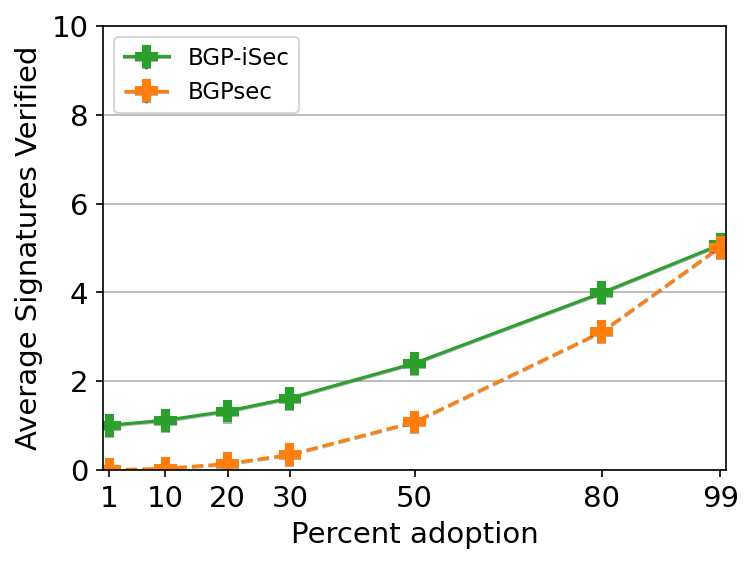

In [259]:
json_data = load_data([f'/home/cam/notebooks/20230121/ezgraphs{i}/results.json' for i in range(100)])

l = get_line("BGPsec", "0", "OverheadBGPsecAS", json_data, "overhead_bpo_all")
l2 = get_line("BGP-iSec", "0", "OverheadBGPsecTransitiveDownOnlyAS", json_data, "overhead_bpo_all")

# forgive me for this bad code it's four hours before the submission deadline
bgpsec = linemap['BGPsec']
bgpisec = linemap['BGP-iSec']
linemap['BGPsec'] = {'color': bgpsec_color, 'marker': overhead_marker, 'linestyle': bgpsec_style}
linemap['BGP-iSec'] = {'color': bgpisec_color, 'marker': overhead_marker, 'linestyle': default_style}

generate_plot([l2, l],
             ylim=10,
             outcome_text="Average Signatures Verified",
             size_inches=(5, 4),
             legend_kwargs={'loc':'upper left', 'prop':{'size': 11}},
             fname="/mnt/c/Users/cam/Pictures/overhead_bpo_graph.pgf")

linemap['BGPsec'] = bgpsec
linemap['BGP-iSec'] = bgpisec

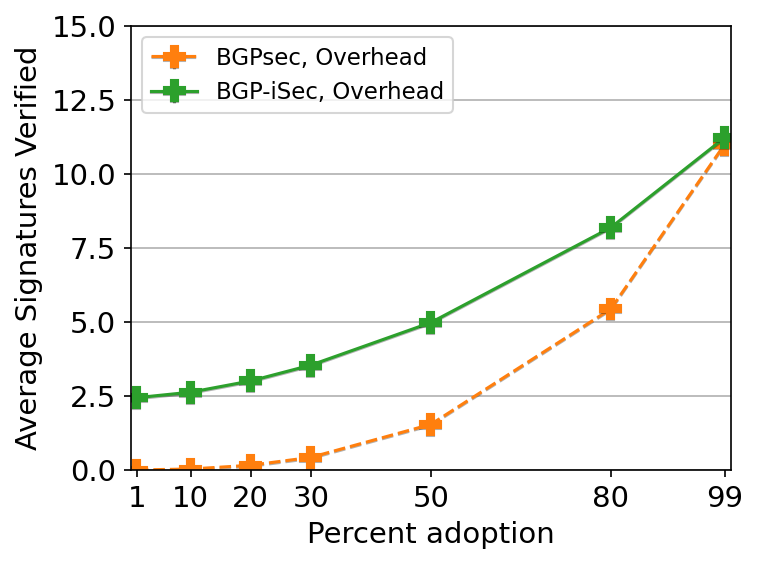

In [4]:
paths = [f'/home/cam/notebooks/20230121/ezgraphs{i}/results.json' for i in range(60)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

result = PolicyResult("overhead_all", "0", "BGP", "OverheadBGPsecAS", json_data)
result2 = PolicyResult("overhead_all", "0", "BGP", "OverheadBGPsecTransitiveDownOnlyAS", json_data)

lines = []
lines.append(Line("BGPsec, Overhead", False, result.non_adopting["overhead_all"]))
lines.append(Line("BGP-iSec, Overhead", False, result2.non_adopting["overhead_all"]))

generate_plot(lines,
             ylim=15,
             outcome_text="Average Signatures Verified",
             size_inches=(5, 4),
             legend_kwargs={'loc':'upper left', 'prop':{'size': 11}},
             fname="/mnt/c/Users/cam/Pictures/overhead_graph.pgf")

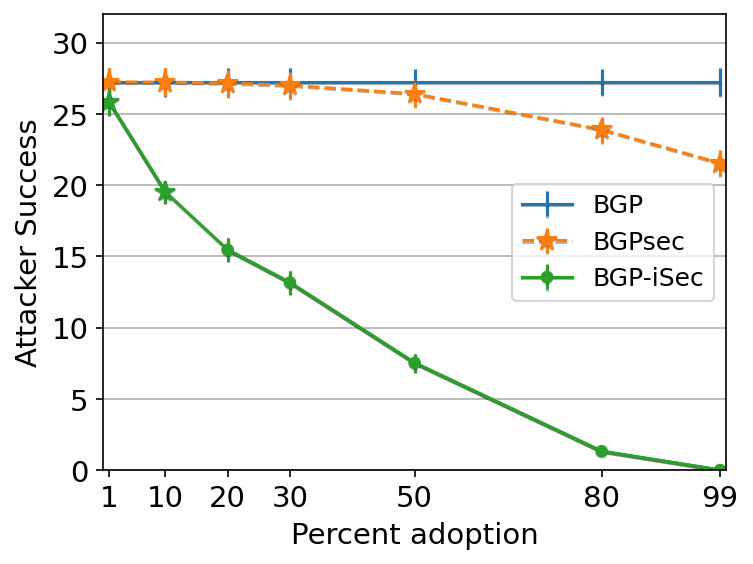

In [79]:
### OLD OPTIMAL GRAPH (NOT IN PAPER) ###


paths = [f'/home/cam/notebooks/20230121/ezgraphs{i}/results.json' for i in range(100)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

result = PolicyResult("attacker_success_all", "1", "BGP", "BaselineBGPAS", json_data)
result2 = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecAggressiveAS", json_data)
result3a = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result3b = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)

lines = []
l: Line = Line("BGP", False, result.non_adopting["attacker_success_all"])
lines.append(deepcopy(l))
lines.append(Line("BGPsec", False, result2.non_adopting["attacker_success_all"]))
l3a: Line = Line("BGP-iSec, Aggressive", False, result3a.non_adopting["attacker_success_all"])
l3b: Line = Line("BGP-iSec", False, result3b.non_adopting["attacker_success_all"])
scale_line(l, l3a)
scale_line(l, l3b)
for line in lines:
    scale_line(l, line)

lines += optimal_line("BGP-iSec+100% ROV, Connector", [l3a, l3b])


generate_plot(lines, ylim=32, outcome_text="Attacker Success",
             size_inches=(5, 4),
             order=(0, 1, 4),
             legend_kwargs={'loc':'center right', 'prop':{'size': 12}},
             fname='/mnt/c/Users/cam/Pictures/optimal_graph.pgf')

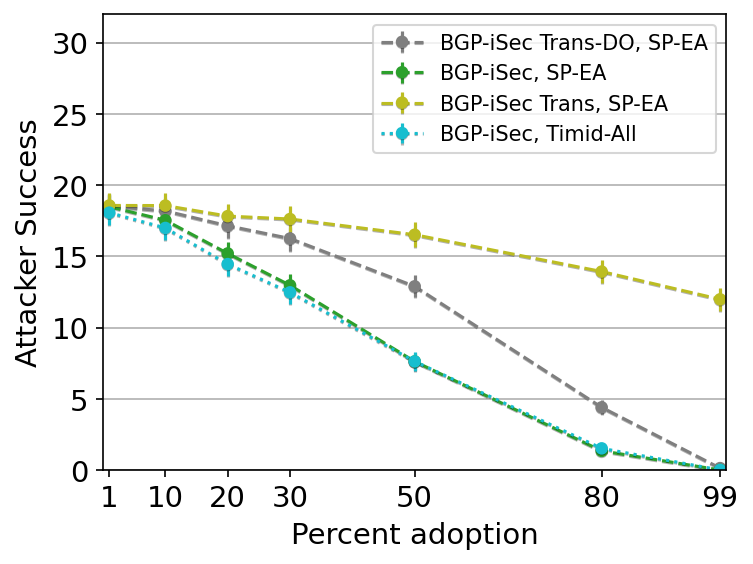

In [16]:
### TIMID VARIANTS (NOT IN PAPER) ###

#gen_adjusted_plot(rootdir, outcome, subgraph_sizes, order=[1, 2, 0, 3], size_inches=(5, 4), fname='/mnt/c/Users/cam/Pictures/timid_variants_graph.pgf',
#             drop_columns=['BGP', 'BGPsec Timid', 'BGPsec Aggressive', 'PaBGPsec Aggressive', 'PaBGPsec No Leak Prevention Aggressive', 'PaBGPsec No Path Shortening Defense Aggressive'],
#             text_replaces=[['PaBGPsec', 'BGP-Isec,'], ['BGPsec Aggressive', 'BGPsec'], ['BGP-Isec, No Leak Prevention', 'BGP-Isec-Trans-Path'], ['BGP-Isec, Timid Leak', 'BGP-Isec, Timid-All'], ['BGP-Isec, No Path Shortening Defense', 'BGP-Isec-Trans-DO,'], ['BGP-Isec-Trans-Path or Path Shortening', 'BGP-Isec-Trans,'], ['Timid', 'Timid-Path'], ['Timid-Path-All', 'Timid-All']],
#             legend_kwargs={'loc':'upper right', 'prop':{'size': 10}})

paths = [f'/home/cam/notebooks/20230121/ezgraphs{i}/results.json' for i in range(100)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

key = "attacker_success_all"
    
result = PolicyResult(key, "1", "BGP", "BaselineBGPAS", json_data)
result2 =  PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyNoHashTimidAS", json_data)
result3 = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result4 = PolicyResult(key, "1", "BGP", "BGPsecTransitiveTimidAS", json_data)
result5 = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyTimidLeakAS", json_data)

lines = []
l: Line = Line("BGP", False, result.non_adopting[key])
lines.append(Line("BGP-iSec Trans-DO, SP-EA", False, result2.non_adopting[key]))
lines.append(Line("BGP-iSec, SP-EA", False, result3.non_adopting[key]))
lines.append(Line("BGP-iSec Trans, SP-EA", False, result4.non_adopting[key]))
lines.append(Line("BGP-iSec, Timid-All", False, result5.non_adopting[key]))

for line in lines:
    scale_line(l, line)

generate_plot(lines, ylim=32, outcome_text="Attacker Success",
             size_inches=(5, 4),
             legend_kwargs={'loc':'upper right', 'prop':{'size': 10}},
             fname='/mnt/c/Users/cam/Pictures/timid_variants_graph.pgf')

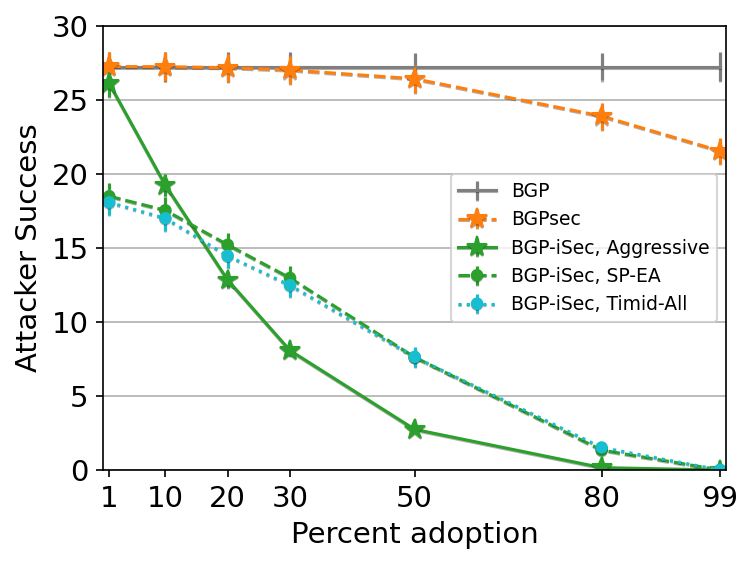

In [17]:
### AGGRESSIVE TIMID (NOT IN PAPER) ###

paths = [f'/home/cam/notebooks/20230121/ezgraphs{i}/results.json' for i in range(100)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

result = PolicyResult("attacker_success_all", "1", "BGP", "BaselineBGPAS", json_data)
result2 = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecAggressiveAS", json_data)
result3 = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result4 = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result5 = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyTimidLeakAS", json_data)

lines = []
l: Line = Line("BGP", False, result.non_adopting["attacker_success_all"])
lines.append(deepcopy(l))
lines.append(Line("BGPsec", False, result2.non_adopting["attacker_success_all"]))
lines.append(Line("BGP-iSec, Aggressive", False, result3.non_adopting["attacker_success_all"]))
lines.append(Line("BGP-iSec, SP-EA", False, result4.non_adopting["attacker_success_all"]))
lines.append(Line("BGP-iSec, Timid-All", False, result5.non_adopting["attacker_success_all"]))

for line in lines:
    scale_line(l, line)

generate_plot(lines, ylim=30, outcome_text="Attacker Success",
             size_inches=(5, 4),
             legend_kwargs={'loc':'center right', 'prop':{'size': 9}},
             fname='/mnt/c/Users/cam/Pictures/aggressive_timid_graph.pgf')

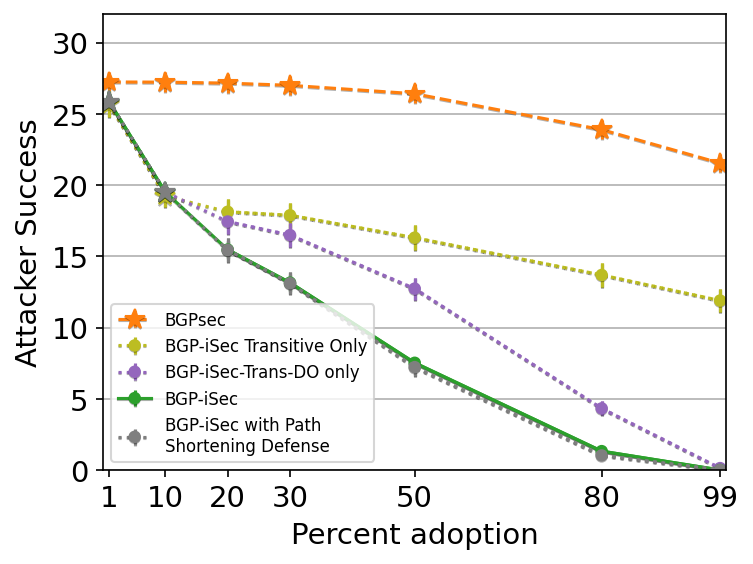

In [68]:
### OPTIMAL VARIANTS ###


paths = [f'/home/cam/notebooks/20230121/ezgraphs{i}/results.json' for i in range(100)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

key = "attacker_success_all"
result = PolicyResult(key, "1", "BGP", "BaselineBGPAS", json_data)
result2 = PolicyResult(key, "1", "BGP", "BGPsecAggressiveAS", json_data)
result3a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result3b = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result4a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveAggressiveAS", json_data)
result4b = PolicyResult(key, "1", "BGP", "BGPsecTransitiveTimidAS", json_data)
result5a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result5b = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyUpTimidAS", json_data)
result6a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result6b = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyNoHashTimidAS", json_data)

lines = []
l: Line = Line("BGP", False, result.non_adopting[key])
#lines.append(deepcopy(l))
lines.append(Line("BGPsec", False, result2.non_adopting[key]))
l2a: Line = Line("BGP-iSec Transitive Only, Aggressive", False, result4a.non_adopting[key])
l2b: Line = Line("BGP-iSec Transitive Only", False, result4b.non_adopting[key])
l3a: Line = Line("BGP-iSec-Trans-DO only, Aggressive", False, result6a.non_adopting[key])
l3b: Line = Line("BGP-iSec-Trans-DO only", False, result6b.non_adopting[key])
l4a: Line = Line("BGP-iSec, Aggressive", False, result3a.non_adopting[key])
l4b: Line = Line("BGP-iSec", False, result3b.non_adopting[key])
l5a: Line = Line("BGP-iSec with Path Shortening Defense, Aggressive", False, result5a.non_adopting[key])
l5b: Line = Line("BGP-iSec with Path Shortening Defense", False, result5b.non_adopting[key])

for line in lines:
    scale_line(l, line)

lines += deepcopy(optimal_line('BGP-iSec Transitive Only, Connector', [l2a, l2b]))
lines += deepcopy(optimal_line("BGP-iSec-Trans-DO only, Connector", [l3a, l3b]))
lines += deepcopy(optimal_line('BGP-iSec, Connector', [l4a, l4b]))
lines += deepcopy(optimal_line("BGP-iSec with Path Shortening Defense, Connector", [l5a, l5b]))

    
generate_plot(lines, ylim=32, outcome_text="Attacker Success",
             size_inches=(5, 4),
             order=[0, 3, 6, 9, 12],
             legend_kwargs={'loc':'lower left', 'prop':{'size': 8}}, 
             textwidth=25,
             fname='/mnt/c/Users/cam/Pictures/optimal_variants_graph.pgf')
# Add UP attribute comparison to this graph or another graph. Assume no global eavesdropping initially, do separate comparison for eavesdropping capability (have both graphs)
# Make sure the attacker doesn't need to receive the announcement for BGPsec Aggressive attack. 

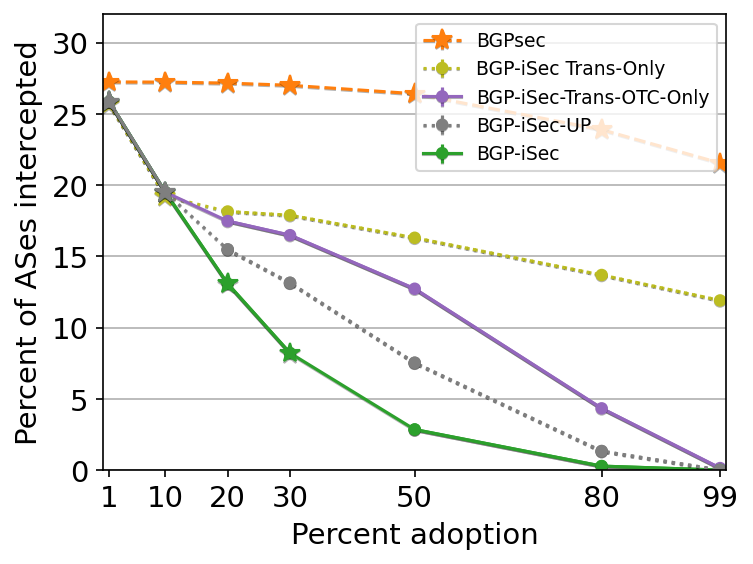

In [237]:
### OPTIMAL VARIANTS GLOBAL ATTACKER ###


key = "attacker_success_all"
result = PolicyResult(key, "1", "BGP", "BaselineBGPAS", json_data)
result2 = PolicyResult(key, "1", "BGP", "BGPsecAggressiveAS", json_data)
result3a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result3b = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result4a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveAggressiveAS", json_data)
result4b = PolicyResult(key, "1", "BGP", "BGPsecTransitiveTimidAS", json_data)
result5a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result5b = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyUpTimidAS", json_data)
result6a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result6b = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyNoHashTimidAS", json_data)
result7 = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyEncrUpGlobalEavesdropperAS", json_data5) # data2 is correct... need to fix this mess later
result8 = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyGlobalEavesdropperAS", json_data5) # data2 is correct... need to fix this mess later

lines = []
l: Line = Line("BGP", False, result.non_adopting[key])
#lines.append(deepcopy(l))
lines.append(Line("BGPsec", False, result2.non_adopting[key]))
l2a: Line = Line("BGP-iSec Transitive-Only, Aggressive", False, result4a.non_adopting[key])
l2b: Line = Line("BGP-iSec Trans-Only", False, result4b.non_adopting[key]) # BGP-iSec Transitive-Only
l3a: Line = Line("BGP-iSec-Trans-DO-Only, Aggressive", False, result6a.non_adopting[key])
l3b: Line = Line("BGP-iSec-Trans-OTC-Only", False, result6b.non_adopting[key]) # BGP-iSec-Trans-DO-Only
l4a: Line = Line("BGP-iSec, Aggressive", False, result3a.non_adopting[key])
l4b: Line = Line("BGP-iSec, Full Attacker", False, result7.non_adopting[key])
l5a: Line = Line("BGP-iSec with Path Shortening Defense, Aggressive", False, result5a.non_adopting[key])
l5b: Line = Line("BGP-iSec with Path Shortening Defense", False, result5b.non_adopting[key])
l6a: Line = Line("BGP-iSec-UP, Aggressive", False, result3a.non_adopting[key])
l6b: Line = Line("BGP-iSec-UP, Global Attacker", False, result3b.non_adopting[key])
l7b: Line = Line("BGP-iSec-UP, Full Attacker", False, result8.non_adopting[key])

for line in lines:
    scale_line(l, line)

lines += deepcopy(optimal_line('BGP-iSec Transitive-Only, Connector', [l2a, l2b]))
lines += deepcopy(optimal_line("BGP-iSec-Trans-DO-Only, Connector", [l3a, l3b]))
lines += deepcopy(optimal_line('BGP-iSec', [l4a, l4b]))
lines += deepcopy(optimal_line('BGP-iSec-UP', [l6a, l6b]))
#lines += deepcopy(optimal_line("BGP-iSec with Path Shortening Defense, Connector", [l5a, l5b]))

    
generate_plot(lines, ylim=32, outcome_text="Percent of ASes intercepted",
             size_inches=(5, 4),
             order=[0, 3, 6, 10, 7],
             legend_kwargs={'loc':'upper right', 'prop':{'size': 9}}, 
             textwidth=35,
             fname='/mnt/c/Users/cam/Pictures/optimal_variants_graph_no_path_shortening.pgf')
#generate_plot(lines, ylim=32, outcome_text="Attacker Success",
#             size_inches=(5, 4),
#             order=[2, 5, 9, 8],
#             legend_kwargs={'loc':'upper right', 'prop':{'size': 9}}, 
#             textwidth=25,
#             fname='/mnt/c/Users/cam/Pictures/optimal_variants_graph_no_path_shortening.pgf')


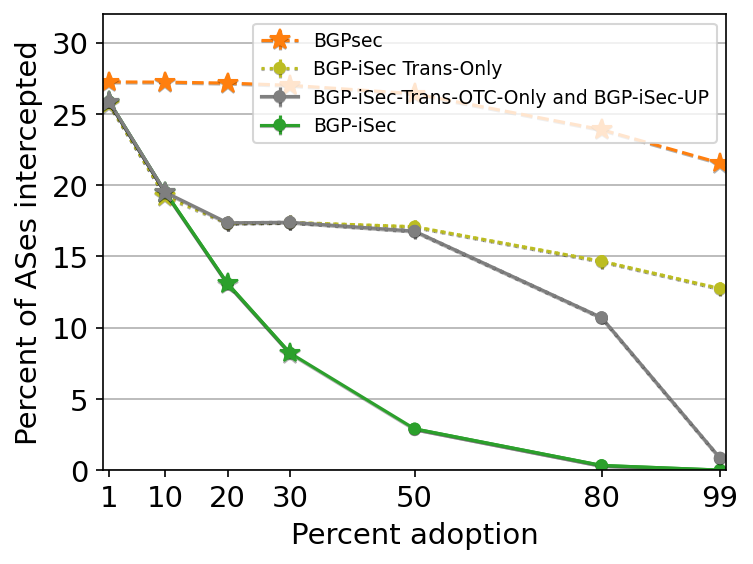

In [254]:
### OPTIMAL VARIANTS FULL ATTACKER ###


key = "attacker_success_all"
result = PolicyResult(key, "1", "BGP", "BaselineBGPAS", json_data)
result2 = PolicyResult(key, "1", "BGP", "BGPsecAggressiveAS", json_data)
result3a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result3b = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result4a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveAggressiveAS", json_data)
result4b = PolicyResult(key, "1", "BGP", "BGPsecTransitiveTimidAS", json_data)
result5a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result5b = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyUpTimidAS", json_data)
result6a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result6b = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyNoHashTimidAS", json_data)
result7 = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyEncrUpGlobalEavesdropperAS", json_data7) # data2 is correct... need to fix this mess later
result8 = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyGlobalEavesdropperAS", json_data7) # data2 is correct... need to fix this mess later
result9 = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveGlobalEavesdropperAS", json_data7) # data2 is correct... need to fix this mess later
result10 = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyUpGlobalEavesdropperAS", json_data7) # data2 is correct... need to fix this mess later


lines = []
l: Line = Line("BGP", False, result.non_adopting[key])
#lines.append(deepcopy(l))
lines.append(Line("BGPsec", False, result2.non_adopting[key]))
l2a: Line = Line("BGP-iSec Transitive-Only, Aggressive", False, result4a.non_adopting[key])
l2b: Line = Line("BGP-iSec Trans-Only", False, result9.non_adopting[key]) # BGP-iSec Transitive-Only
l3a: Line = Line("BGP-iSec-Trans-DO-Only, Aggressive", False, result6a.non_adopting[key])
l3b: Line = Line("BGP-iSec-Trans-OTC-Only", False, result8.non_adopting[key]) # BGP-iSec-Trans-DO-Only
l4a: Line = Line("BGP-iSec, Aggressive", False, result3a.non_adopting[key])
l4b: Line = Line("BGP-iSec, Full Attacker", False, result7.non_adopting[key])
l5a: Line = Line("BGP-iSec with Path Shortening Defense, Aggressive", False, result5a.non_adopting[key])
l5b: Line = Line("BGP-iSec with Path Shortening Defense", False, result5b.non_adopting[key])
l6a: Line = Line("BGP-iSec-UP, Aggressive", False, result3a.non_adopting[key])
l6b: Line = Line("BGP-iSec-UP, Global Attacker", False, result10.non_adopting[key])
l7b: Line = Line("BGP-iSec-UP, Full Attacker", False, result8.non_adopting[key])

for line in lines:
    scale_line(l, line)

lines += deepcopy(optimal_line('BGP-iSec Transitive-Only, Connector', [l2a, l2b]))
#lines += deepcopy(optimal_line("BGP-iSec-Trans-DO-Only, Connector", [l3a, l3b]))
lines += deepcopy(optimal_line('BGP-iSec', [l4a, l4b]))
lines += deepcopy(optimal_line('BGP-iSec-Trans-OTC-Only and BGP-iSec-UP', [l6a, l6b]))
#lines += deepcopy(optimal_line("BGP-iSec with Path Shortening Defense, Connector", [l5a, l5b]))

    
generate_plot(lines, ylim=32, outcome_text="Percent of ASes intercepted",
             size_inches=(5, 4),
             order=[0, 3, 7, 4],
             legend_kwargs={'loc':'upper right', 'prop':{'size': 9}}, 
             textwidth=40,
             fname='/mnt/c/Users/cam/Pictures/optimal_variants_graph_no_path_shortening_full.pgf')
#generate_plot(lines, ylim=32, outcome_text="Attacker Success",
#             size_inches=(5, 4),
#             order=[2, 5, 9, 8],
#             legend_kwargs={'loc':'upper right', 'prop':{'size': 9}}, 
#             textwidth=25,
#             fname='/mnt/c/Users/cam/Pictures/optimal_variants_graph_no_path_shortening.pgf')


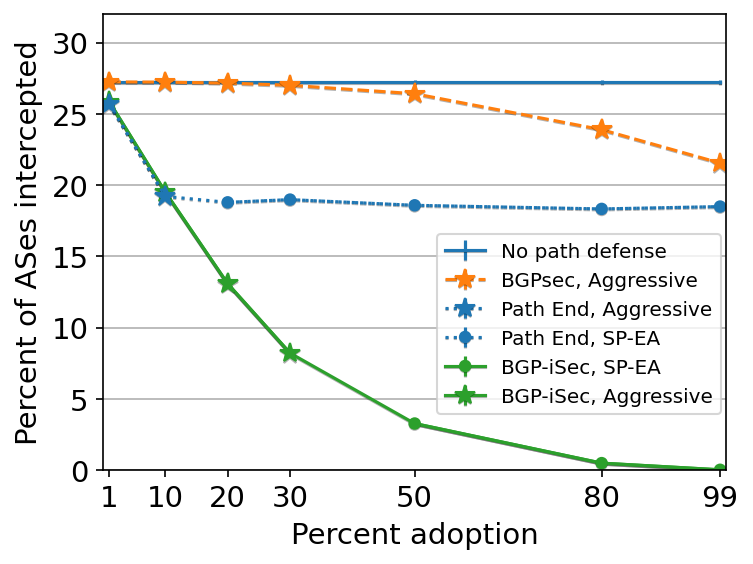

In [227]:
### NEW OPTIMAL GRAPH ###

#paths = [f'/home/cam/notebooks/20230121/ezgraphs{i}/results.json' for i in range(100)]
#json_data = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data.append(json.load(json_file))

result = PolicyResult("attacker_success_all", "1", "BGP", "BaselineBGPAS", json_data)
result2 = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecAggressiveAS", json_data)
result3a = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result3b = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result4a = PolicyResult("attacker_success_all", "1", "BGP", "PathEndAggressiveAS", json_data)
result4b = PolicyResult("attacker_success_all", "1", "BGP", "PathEndTimidAS", json_data)
result5 = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyEncrUpGlobalEavesdropperAS", json_data2)

lines = []
l: Line = Line("No path defense", False, result.non_adopting["attacker_success_all"])
lines.append(deepcopy(l))
lines.append(Line("BGPsec, Aggressive", False, result2.non_adopting["attacker_success_all"]))
l3a: Line = Line("BGP-iSec, Aggressive", False, result3a.non_adopting["attacker_success_all"])
l3b: Line = Line("BGP-iSec, SP-EA", False, result5.non_adopting["attacker_success_all"])
l4a: Line = Line("Path End, Aggressive", False, result4a.non_adopting["attacker_success_all"])
l4b: Line = Line("Path End, SP-EA", False, result4b.non_adopting["attacker_success_all"])


scale_line(l, l3a)
scale_line(l, l3b)
scale_line(l, l4a)
scale_line(l, l4b)
for line in lines:
    scale_line(l, line)
    
lines += optimal_line("BGP-iSec, Connector", [l3a, l3b])
lines += optimal_line("Path End, Connector", [l4a, l4b])

generate_plot(lines, ylim=32, outcome_text="Percent of ASes intercepted",
             size_inches=(5, 4),
             order=[0, 1, 6, 7, 4, 3],
             legend_kwargs={'bbox_to_anchor':[0.52, 0.54], 'prop':{'size': 9.6}},
             fname='/mnt/c/Users/cam/Pictures/optimal_graph.pgf')
# Explain more clearly and maybe show how the path end line is made from both attacks
# Why are path end and BGPsecTransitive not the same? Should they be the same? Yes.

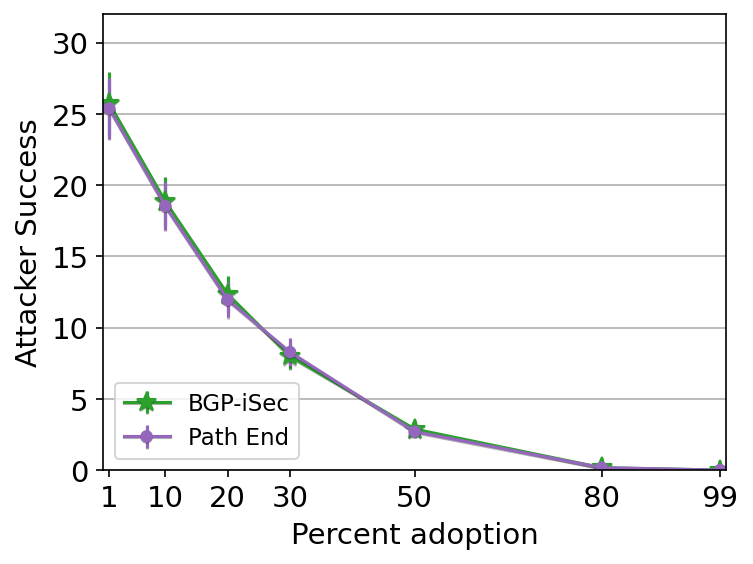

In [219]:
### Path End Comparison Scaled ###

paths = [f'/home/cam/notebooks/tmp21/ezgraphs{i}/results.json' for i in range(60)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

result = PolicyResult("attacker_success_all", "1", "BGP", "BaselineBGPAS", json_data)
result2 = PolicyResult("attacker_success_all", "0", "BGP", "BGPsecAggressiveAS", json_data)
result3a = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveAggressiveAS", json_data)
result3b = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result4a = PolicyResult("attacker_success_all", "0", "BGP", "PathEndAggressiveAS", json_data)
result4b = PolicyResult("attacker_success_all", "1", "BGP", "PathEndTimidAS", json_data)


l: Line = Line("BGP", False, result.non_adopting["attacker_success_all"])
l1 = deepcopy(l)
l2: Line = Line("BGPsec", False, result2.non_adopting["attacker_success_all"])
l3a: Line = Line("BGP-iSec", False, result3a.non_adopting["attacker_success_all"])
l3b: Line = Line("BGP-iSec", False, result3b.non_adopting["attacker_success_all"])
l3 = optimal_line([l3a, l3b])[0]
l4a: Line = Line("Path End", False, result4a.non_adopting["attacker_success_all"])
l4b: Line = Line("Path End", False, result4b.non_adopting["attacker_success_all"])
l4 = optimal_line([l4a, l4b])[0]


scale_line(l, l1)
scale_line(l, l2)
scale_line(l, l3)
scale_line(l, l4)


generate_plot([l3a, l4a], ylim=32, outcome_text="Attacker Success",
             size_inches=(5, 4),
             legend_kwargs={'loc':'lower left', 'prop':{'size': 11}},
             fname='/mnt/c/Users/cam/Pictures/path_end_comparison_aggressive.pgf')

KeyError: 'BGP-iSec, SP-EA'

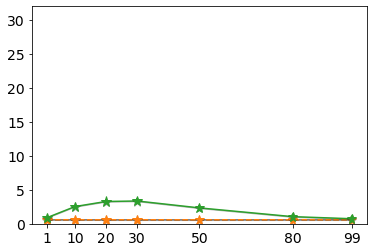

In [12]:
### AGGRESSIVE TIMID DISCONNECTED ###

paths = [f'/home/cam/notebooks/tmp21/ezgraphs{i}/results.json' for i in range(50)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

result = PolicyResult("disconnected_all", "1", "BGP", "BaselineBGPAS", json_data)
result2 = PolicyResult("disconnected_all", "1", "BGP", "BGPsecAggressiveAS", json_data)
result3 = PolicyResult("disconnected_all", "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result4 = PolicyResult("disconnected_all", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result4 = PolicyResult("disconnected_all", "1", "BGP", "BGPsecTransitiveDownOnlyTimidLeakAS", json_data)

l: Line = Line("BGP", False, result.non_adopting["disconnected_all"])
l2: Line = Line("BGPsec", False, result2.non_adopting["disconnected_all"])
l3: Line = Line("BGP-iSec, Aggressive", False, result3.non_adopting["disconnected_all"])
l4: Line = Line("BGP-iSec, SP-EA", False, result4.non_adopting["disconnected_all"])
l5: Line = Line("BGP-iSec, Timid-All", False, result4.non_adopting["disconnected_all"])

generate_plot([l, l2, l3, l4, l5], ylim=32, outcome_text="Attacker Success",
             size_inches=(5, 4),
             legend_kwargs={'loc':'center right', 'prop':{'size': 9}},
             fname='/mnt/c/Users/cam/Pictures/aggressive_timid_disconnected_graph.pgf')

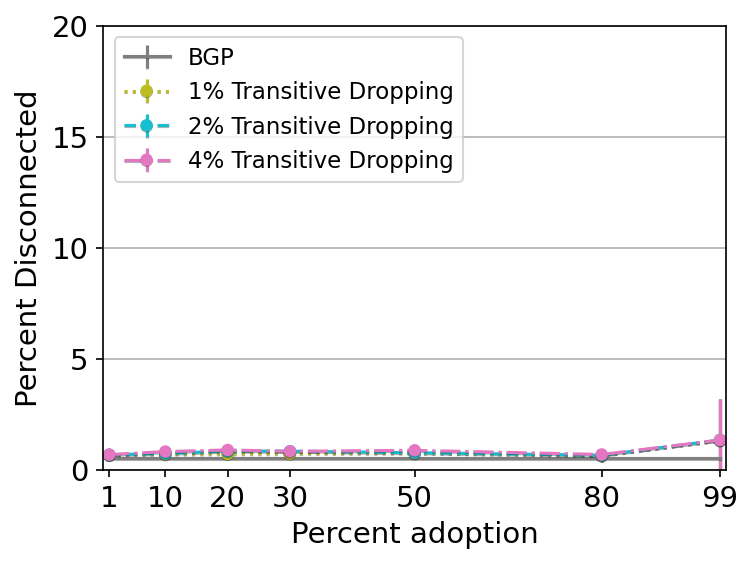

In [27]:
### Path End Comparison Scaled ###

#paths = [f'/home/cam/notebooks/tmp26/ezgraphs{i}/results.json' for i in range(60)]
paths = [f'/home/cam/notebooks/tmp34/ezgraphs{i}/results.json' for i in range(60)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

result = PolicyResult("disconnected_non_adopting_stubs_and_multihomed", "0", "BGP", "BaselineBGPAS", json_data)
#result2 = PolicyResult("disconnected_all", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result3 = PolicyResult("disconnected_non_adopting_stubs_and_multihomed", "0", "TransitiveDroppingAS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping1AS", json_data)
result4 = PolicyResult("disconnected_non_adopting_stubs_and_multihomed", "0", "TransitiveDropping2AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping2AS", json_data)
result5 = PolicyResult("disconnected_non_adopting_stubs_and_multihomed", "0", "TransitiveDropping4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping4AS", json_data) # yes this typo is correct

subgraph_sizes = {
    'etc': 11330,
    'input_clique': 19,
    'mh': 35464,
    'stubs': 26430,
}


l: Line = Line("BGP", False, result.non_adopting["disconnected_non_adopting_stubs_and_multihomed"])
l1 = deepcopy(l)
#l2: Line = Line("No Transitive Dropping", False, result2.non_adopting["disconnected_all"])
l3: Line = Line("1% Transitive Dropping", False, result3.non_adopting["disconnected_non_adopting_stubs_and_multihomed"])
l4: Line = Line("2% Transitive Dropping", False, result4.non_adopting["disconnected_non_adopting_stubs_and_multihomed"])
l5: Line = Line("4% Transitive Dropping", False, result5.non_adopting["disconnected_non_adopting_stubs_and_multihomed"])


scale_line(l, l1)
scale_line(l, l2)
scale_line(l, l3)
scale_line(l, l4)
scale_line(l, l5)


generate_plot([l1, l3, l4, l5], ylim=20, outcome_text="Percent Disconnected",
             size_inches=(5, 4),
             legend_kwargs={'loc':'upper left', 'prop':{'size': 11}},
             fname='/mnt/c/Users/cam/Pictures/transitive_dropping_graph_non_adopting.pgf')

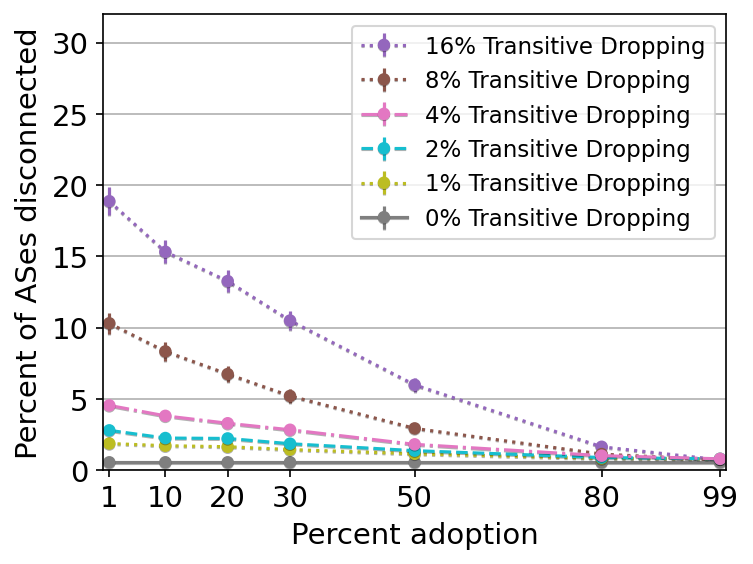

In [234]:
### TRANSITIVE DROPPING ###

#paths = [f'/home/cam/notebooks/tmp26/ezgraphs{i}/results.json' for i in range(60)]
#paths = [f'/home/cam/notebooks/tmp34/ezgraphs{i}/results.json' for i in range(60)]
#paths = [f'/home/cam/notebooks/tmp43/ezgraphs{i}/results.json' for i in range(100)]
#json_data3 = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data3.append(json.load(json_file))

#paths = [f'/home/cam/notebooks/tmp33/ezgraphs{i}/results.json' for i in range(60)]
#json_data4 = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data4.append(json.load(json_file))


result1 = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "BGP", "BaselineBGPAS", json_data)
result2 = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "TransitiveDroppingNoAdoptCustomersAS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers1AS", json_data3)
result3 = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "TransitiveDroppingNoAdoptCustomers2AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers2AS", json_data3)
result4 = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "TransitiveDroppingNoAdoptCustomers4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers4AS", json_data3) # yes this typo is correct

result5 = PolicyResult("disconnected_adopting_etc", "0", "TransitiveDroppingNoAdoptCustomersAS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers1AS", json_data3)
result6 = PolicyResult("disconnected_adopting_etc", "0", "TransitiveDroppingNoAdoptCustomers2AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers2AS", json_data3)
result7 = PolicyResult("disconnected_adopting_etc", "0", "TransitiveDroppingNoAdoptCustomers4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers4AS", json_data3) # yes this typo is correct

result8 = PolicyResult("disconnected_adopting_input_clique", "0", "TransitiveDroppingNoAdoptCustomersAS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers1AS", json_data3)
result9 = PolicyResult("disconnected_adopting_input_clique", "0", "TransitiveDroppingNoAdoptCustomers2AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers2AS", json_data3)
result10 = PolicyResult("disconnected_adopting_input_clique", "0", "TransitiveDroppingNoAdoptCustomers4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers4AS", json_data3) # yes this typo is correct

result11 = PolicyResult("disconnected_adopting_stubs_and_multihomed", "1", "TransitiveDroppingNoAdoptCustomers8AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers8AS", json_data6) 
result12 = PolicyResult("disconnected_adopting_stubs_and_multihomed", "1", "TransitiveDroppingNoAdoptCustomers16AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers16AS", json_data6)

result13 = PolicyResult("disconnected_adopting_etc", "1", "TransitiveDroppingNoAdoptCustomers8AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers8AS", json_data6) 
result14 = PolicyResult("disconnected_adopting_etc", "1", "TransitiveDroppingNoAdoptCustomers16AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers16AS", json_data6)

result15 = PolicyResult("disconnected_adopting_input_clique", "1", "TransitiveDroppingNoAdoptCustomers8AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers8AS", json_data6) 
result16 = PolicyResult("disconnected_adopting_input_clique", "1", "TransitiveDroppingNoAdoptCustomers16AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers16AS", json_data6)


subgraph_sizes = {
    'etc': 11330,
    'input_clique': 19,
    'mh': 35464,
    'stubs': 26430,
}


l: Line = Line("0% Transitive Dropping", False, result1.non_adopting["disconnected_adopting_stubs_and_multihomed"])
l1 = deepcopy(l)

l2: Line = Line("1% Transitive Dropping", False, result2.non_adopting["disconnected_adopting_stubs_and_multihomed"])
l3: Line = Line("2% Transitive Dropping", False, result3.non_adopting["disconnected_adopting_stubs_and_multihomed"])
l4: Line = Line("4% Transitive Dropping", False, result4.non_adopting["disconnected_adopting_stubs_and_multihomed"])

l5: Line = Line("1% Transitive Dropping", False, result5.non_adopting["disconnected_adopting_etc"])
l6: Line = Line("2% Transitive Dropping", False, result6.non_adopting["disconnected_adopting_etc"])
l7: Line = Line("4% Transitive Dropping", False, result7.non_adopting["disconnected_adopting_etc"])

l8: Line = Line("1% Transitive Dropping", False, result8.non_adopting["disconnected_adopting_input_clique"])
l9: Line = Line("2% Transitive Dropping", False, result9.non_adopting["disconnected_adopting_input_clique"])
l10: Line = Line("4% Transitive Dropping", False, result10.non_adopting["disconnected_adopting_input_clique"])

l11: Line = Line("8% Transitive Dropping", False, result11.non_adopting["disconnected_adopting_stubs_and_multihomed"])
l12: Line = Line("16% Transitive Dropping", False, result12.non_adopting["disconnected_adopting_stubs_and_multihomed"])

l13: Line = Line("8% Transitive Dropping", False, result13.non_adopting["disconnected_adopting_etc"])
l14: Line = Line("16% Transitive Dropping", False, result14.non_adopting["disconnected_adopting_etc"])

l15: Line = Line("8% Transitive Dropping", False, result15.non_adopting["disconnected_adopting_input_clique"])
l16: Line = Line("16% Transitive Dropping", False, result16.non_adopting["disconnected_adopting_input_clique"])

scale_line(l, l1)
scale_line(l, l2)
scale_line(l, l3)
scale_line(l, l4)
scale_line(l, l5)
scale_line(l, l6)
scale_line(l, l7)
scale_line(l, l8)
scale_line(l, l9)
scale_line(l, l10)

combine_adopting_line(l2, l5, l8)
combine_adopting_line(l3, l6, l9)
combine_adopting_line(l4, l7, l10)
combine_adopting_line(l11, l13, l15)
combine_adopting_line(l12, l14, l16)

generate_plot([l12, l11, l1, l2, l3, l4], ylim=32, outcome_text="Percent of ASes disconnected",
             size_inches=(5, 4),
             order=(0, 1, 5, 4, 3, 2),
             legend_kwargs={'loc':'upper right', 'prop':{'size': 11}},
             fname='/mnt/c/Users/cam/Pictures/transitive_dropping_graph_adopting.pgf')
#generate_plot([l1, l2, l3, l4], ylim=20, outcome_text="Percent Disconnected",
#             size_inches=(5, 4),
#             order=(3, 2, 1, 0),
#             legend_kwargs={'loc':'upper right', 'prop':{'size': 11}},
#             fname='/mnt/c/Users/cam/Pictures/transitive_dropping_graph_adopting.pgf')

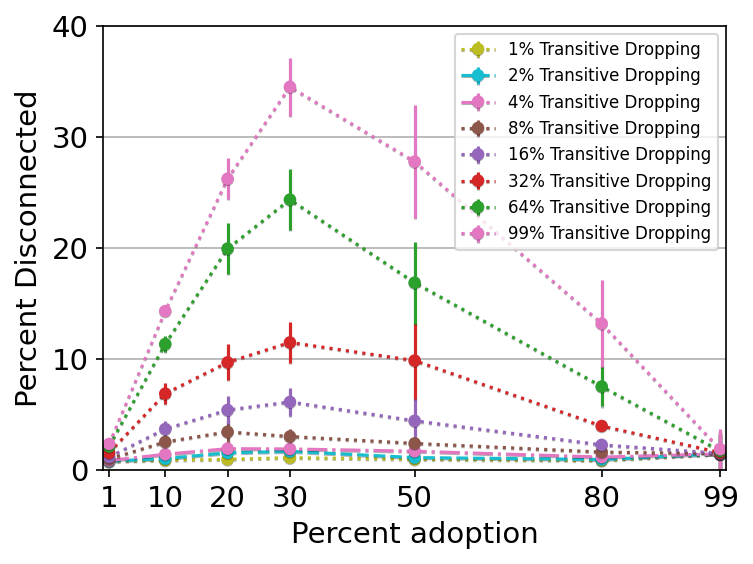

In [467]:
### Path End Comparison Scaled ###

#paths = [f'/home/cam/notebooks/tmp26/ezgraphs{i}/results.json' for i in range(60)]
paths = [f'/home/cam/notebooks/tmp34/ezgraphs{i}/results.json' for i in range(60)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

#result = PolicyResult("disconnected_all", "0", "BGP", "BaselineBGPAS", json_data)
#result2 = PolicyResult("disconnected_all", "0", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result3 = PolicyResult("disconnected_all", "0", "TransitiveDroppingAS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping1AS", json_data)
result4 = PolicyResult("disconnected_all", "0", "TransitiveDropping2AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping2AS", json_data)
result5 = PolicyResult("disconnected_all", "0", "TransitiveDropping4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping4AS", json_data) 
result6 = PolicyResult("disconnected_all", "0", "TransitiveDropping8AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping8AS", json_data) 
result7 = PolicyResult("disconnected_all", "0", "TransitiveDropping16AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping16AS", json_data)
result8 = PolicyResult("disconnected_all", "0", "TransitiveDropping32AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping32AS", json_data)
result9 = PolicyResult("disconnected_all", "0", "TransitiveDropping64AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping64AS", json_data)
result10 = PolicyResult("disconnected_all", "0", "TransitiveDropping99AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping99AS", json_data)

#l: Line = Line("BGP", False, result.non_adopting["disconnected_all"])
#l1 = deepcopy(l)
#l2: Line = Line("No Transitive Dropping", False, result2.non_adopting["disconnected_all"])
l3: Line = Line("1% Transitive Dropping", False, result3.non_adopting["disconnected_all"])
l4: Line = Line("2% Transitive Dropping", False, result4.non_adopting["disconnected_all"])
l5: Line = Line("4% Transitive Dropping", False, result5.non_adopting["disconnected_all"])
l6: Line = Line("8% Transitive Dropping", False, result6.non_adopting["disconnected_all"])
l7: Line = Line("16% Transitive Dropping", False, result7.non_adopting["disconnected_all"])
l8: Line = Line("32% Transitive Dropping", False, result8.non_adopting["disconnected_all"])
l9: Line = Line("64% Transitive Dropping", False, result9.non_adopting["disconnected_all"])
l10: Line = Line("99% Transitive Dropping", False, result10.non_adopting["disconnected_all"])


#scale_line(l, l1)
#scale_line(l, l2)
scale_line(l, l3)
scale_line(l, l4)
scale_line(l, l5)
scale_line(l, l6)
scale_line(l, l7)
scale_line(l, l8)
scale_line(l, l9)
scale_line(l, l10)



generate_plot([l3, l4, l5, l6, l7, l8, l9, l10], ylim=40, outcome_text="Percent Disconnected",
             size_inches=(5, 4),
             legend_kwargs={'loc':'upper right', 'prop':{'size': 8}},
             fname='/mnt/c/Users/cam/Pictures/transitive_dropping_graph.pgf')

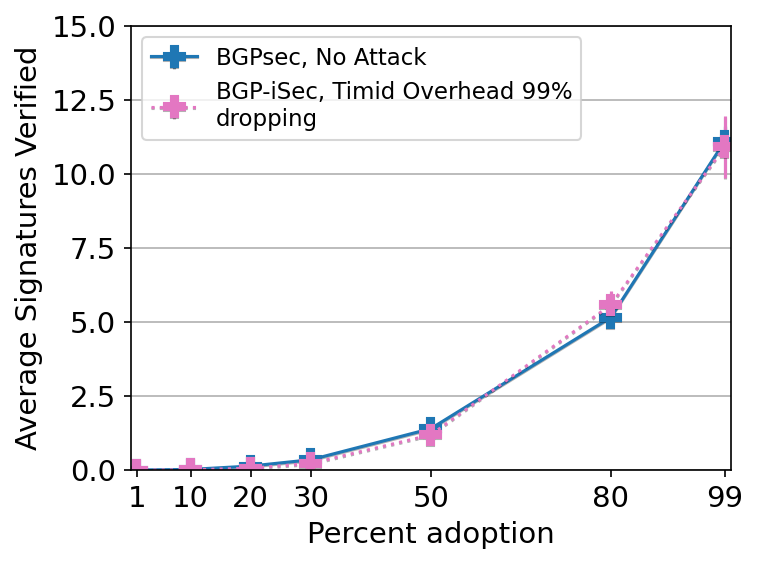

In [262]:
paths = [f'/home/cam/notebooks/tmp27/ezgraphs{i}/results.json' for i in range(60)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

result = PolicyResult("overhead_all", "0", "TransitiveDroppingAS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping1AS", json_data)
result2 = PolicyResult("overhead_all", "0", "TransitiveDropping4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppint4AS", json_data)

#l: Line = Line("BGPsec, No Attack", False, result.non_adopting["overhead_all"])
l2: Line = Line("BGP-iSec, Timid Overhead 99% dropping", False, result2.non_adopting["overhead_all"])

paths = [f'/home/cam/notebooks/tmp21/ezgraphs{i}/results.json' for i in range(60)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))
result = PolicyResult("overhead_all", "0", "BGP", "OverheadBGPsecAS", json_data)
l: Line = Line("BGPsec, No Attack", False, result.non_adopting["overhead_all"])

generate_plot([l, l2],
             ylim=15,
             outcome_text="Average Signatures Verified",
             size_inches=(5, 4),
             legend_kwargs={'loc':'upper left', 'prop':{'size': 11}},
             fname="/mnt/c/Users/cam/Pictures/overhead_graph.pgf")

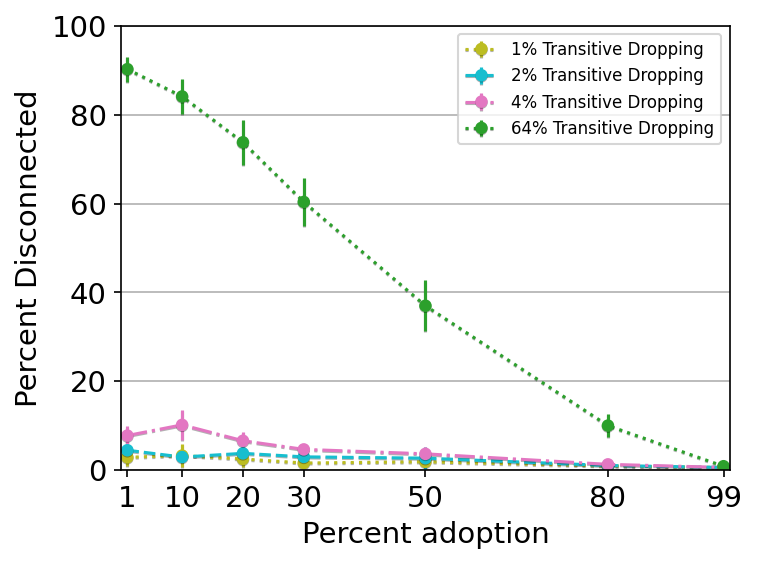

In [402]:
### Path End Comparison Scaled ###

#paths = [f'/home/cam/notebooks/tmp26/ezgraphs{i}/results.json' for i in range(60)]
paths = [f'/home/cam/notebooks/tmp33/ezgraphs{i}/results.json' for i in range(60)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

#result = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "BGP", "BaselineBGPAS", json_data)
#result2 = PolicyResult("disconnected_all", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result3 = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "TransitiveDroppingAS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping1AS", json_data)
result4 = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "TransitiveDropping2AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping2AS", json_data)
result5 = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "TransitiveDropping4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping4AS", json_data) # yes this typo is correct
result5 = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "TransitiveDropping4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping4AS", json_data) # yes this typo is correct
result6 = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "TransitiveDropping64AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping64AS", json_data) # yes this typo is correct


#l: Line = Line("BGP", False, result.non_adopting["disconnected_adopting_stubs_and_multihomed"])
#l1 = deepcopy(l)
#l2: Line = Line("No Transitive Dropping", False, result2.non_adopting["disconnected_all"])
l3: Line = Line("1% Transitive Dropping", False, result3.non_adopting["disconnected_adopting_stubs_and_multihomed"])
l4: Line = Line("2% Transitive Dropping", False, result4.non_adopting["disconnected_adopting_stubs_and_multihomed"])
l5: Line = Line("4% Transitive Dropping", False, result5.non_adopting["disconnected_adopting_stubs_and_multihomed"])
l6: Line = Line("64% Transitive Dropping", False, result6.non_adopting["disconnected_adopting_stubs_and_multihomed"])


#scale_line(l, l1)
#scale_line(l, l2)
#scale_line(l, l3)
#scale_line(l, l4)
#scale_line(l, l5)


generate_plot([l3, l4, l5, l6], ylim=100, outcome_text="Percent Disconnected",
             size_inches=(5, 4),
             legend_kwargs={'loc':'upper right', 'prop':{'size': 8}},
             fname='/mnt/c/Users/cam/Pictures/transitive_dropping_graph.pgf')

In [396]:
### Path End Comparison Scaled ###

#paths = [f'/home/cam/notebooks/tmp26/ezgraphs{i}/results.json' for i in range(60)]
paths = [f'/home/cam/notebooks/tmp33/ezgraphs{i}/results.json' for i in range(60)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

result = PolicyResult("path_len_all", "1", "BGP", "BaselineBGPAS", json_data)
result2 = PolicyResult("path_len_all", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result3 = PolicyResult("path_len_all", "1", "TransitiveDroppingAS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping1AS", json_data)
result4 = PolicyResult("path_len_all", "1", "TransitiveDropping2AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping2AS", json_data)
result5 = PolicyResult("path_len_all", "1", "TransitiveDropping4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping4AS", json_data) 
result6 = PolicyResult("path_len_all", "1", "TransitiveDropping8AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping8AS", json_data) 
result7 = PolicyResult("path_len_all", "1", "TransitiveDropping16AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping16AS", json_data)
result8 = PolicyResult("path_len_all", "1", "TransitiveDropping32AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping32AS", json_data)
result9 = PolicyResult("path_len_all", "1", "TransitiveDropping64AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping64AS", json_data)

l: Line = Line("BGP", False, result.non_adopting["path_len_all"])
l1 = deepcopy(l)
l2: Line = Line("No Transitive Dropping", False, result2.non_adopting["path_len_all"])
l3: Line = Line("1% Transitive Dropping", False, result3.non_adopting["path_len_all"])
l4: Line = Line("2% Transitive Dropping", False, result4.non_adopting["path_len_all"])
l5: Line = Line("4% Transitive Dropping", False, result5.non_adopting["path_len_all"])
l6: Line = Line("8% Transitive Dropping", False, result6.non_adopting["path_len_all"])
l7: Line = Line("16% Transitive Dropping", False, result7.non_adopting["path_len_all"])
l8: Line = Line("32% Transitive Dropping", False, result8.non_adopting["path_len_all"])
l9: Line = Line("64% Transitive Dropping", False, result9.non_adopting["path_len_all"])


#scale_line(l, l1)
#scale_line(l, l2)
#scale_line(l, l3)
#scale_line(l, l4)
#scale_line(l, l5)
#scale_line(l, l6)
#scale_line(l, l7)
#scale_line(l, l8)
#scale_line(l, l9)


generate_plot([l1, l2, l3, l4, l5, l6, l7, l8, l9], ylim=15, outcome_text="Average Path Length",
             size_inches=(5, 4),
             legend_kwargs={'loc':'upper left', 'prop':{'size': 8}},
             fname='/mnt/c/Users/cam/Pictures/transitive_dropping_graph.pgf')

KeyError: 'BGP (BGPsecTransitiveDownOnlyNoHashUpTimidAS adopting)'

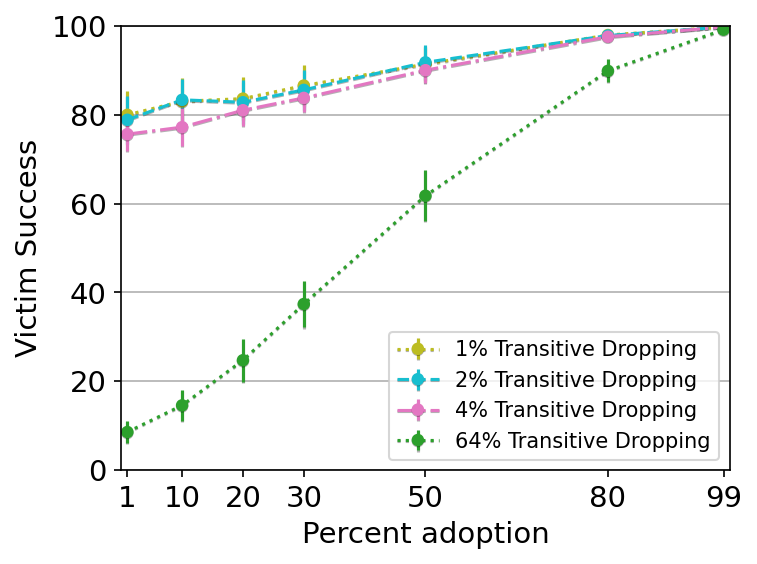

In [390]:
### Path End Comparison Scaled ###

#paths = [f'/home/cam/notebooks/tmp26/ezgraphs{i}/results.json' for i in range(60)]
paths = [f'/home/cam/notebooks/tmp33/ezgraphs{i}/results.json' for i in range(60)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

#result = PolicyResult("victim_success_adopting_stubs_and_multihomed", "1", "BGP", "BaselineBGPAS", json_data)
#result2 = PolicyResult("disconnected_all", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result3 = PolicyResult("victim_success_adopting_stubs_and_multihomed", "1", "TransitiveDroppingAS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping1AS", json_data)
result4 = PolicyResult("victim_success_adopting_stubs_and_multihomed", "1", "TransitiveDropping2AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping2AS", json_data)
result5 = PolicyResult("victim_success_adopting_stubs_and_multihomed", "1", "TransitiveDropping4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping4AS", json_data) # yes this typo is correct
result5 = PolicyResult("victim_success_adopting_stubs_and_multihomed", "1", "TransitiveDropping4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping4AS", json_data) # yes this typo is correct
result6 = PolicyResult("victim_success_adopting_stubs_and_multihomed", "1", "TransitiveDropping64AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping64AS", json_data) # yes this typo is correct


#l: Line = Line("BGP", False, result.non_adopting["victim_success_adopting_stubs_and_multihomed"])
#l1 = deepcopy(l)
#l2: Line = Line("No Transitive Dropping", False, result2.non_adopting["disconnected_all"])
l3: Line = Line("1% Transitive Dropping", False, result3.non_adopting["victim_success_adopting_stubs_and_multihomed"])
l4: Line = Line("2% Transitive Dropping", False, result4.non_adopting["victim_success_adopting_stubs_and_multihomed"])
l5: Line = Line("4% Transitive Dropping", False, result5.non_adopting["victim_success_adopting_stubs_and_multihomed"])
l6: Line = Line("64% Transitive Dropping", False, result6.non_adopting["victim_success_adopting_stubs_and_multihomed"])


#scale_line(l, l1)
scale_line(l, l2)
scale_line(l, l3)
scale_line(l, l4)
scale_line(l, l5)


generate_plot([l3, l4, l5, l6], ylim=100, outcome_text="Victim Success",
             size_inches=(5, 4),
             legend_kwargs={'loc':'lower right', 'prop':{'size': 10}},
             fname='/mnt/c/Users/cam/Pictures/transitive_dropping_graph.pgf')

In [387]:
### Path End Comparison Scaled ###

#paths = [f'/home/cam/notebooks/tmp26/ezgraphs{i}/results.json' for i in range(60)]
paths = [f'/home/cam/notebooks/tmp33/ezgraphs{i}/results.json' for i in range(60)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

result = PolicyResult("victim_success_non_adopting_stubs_and_multihomed", "1", "BGP", "BaselineBGPAS", json_data)
#result2 = PolicyResult("disconnected_all", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result3 = PolicyResult("victim_success_non_adopting_stubs_and_multihomed", "1", "TransitiveDroppingAS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping1AS", json_data)
result4 = PolicyResult("victim_success_non_adopting_stubs_and_multihomed", "1", "TransitiveDropping2AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping2AS", json_data)
result5 = PolicyResult("victim_success_non_adopting_stubs_and_multihomed", "1", "TransitiveDropping4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping4AS", json_data) # yes this typo is correct
result5 = PolicyResult("victim_success_non_adopting_stubs_and_multihomed", "1", "TransitiveDropping4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping4AS", json_data) # yes this typo is correct
result6 = PolicyResult("victim_success_non_adopting_stubs_and_multihomed", "1", "TransitiveDropping64AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping64AS", json_data) # yes this typo is correct


l: Line = Line("BGP", False, result.non_adopting["victim_success_non_adopting_stubs_and_multihomed"])
l1 = deepcopy(l)
#l2: Line = Line("No Transitive Dropping", False, result2.non_adopting["disconnected_all"])
l3: Line = Line("1% Transitive Dropping", False, result3.non_adopting["victim_success_non_adopting_stubs_and_multihomed"])
l4: Line = Line("2% Transitive Dropping", False, result4.non_adopting["victim_success_non_adopting_stubs_and_multihomed"])
l5: Line = Line("4% Transitive Dropping", False, result5.non_adopting["victim_success_non_adopting_stubs_and_multihomed"])
l6: Line = Line("64% Transitive Dropping", False, result6.non_adopting["victim_success_non_adopting_stubs_and_multihomed"])


scale_line(l, l1)
scale_line(l, l2)
scale_line(l, l3)
scale_line(l, l4)
scale_line(l, l5)


generate_plot([l1, l3, l4, l5, l6], ylim=100, outcome_text="Victim Success",
             size_inches=(5, 4),
             legend_kwargs={'loc':'lower right', 'prop':{'size': 10}},
             fname='/mnt/c/Users/cam/Pictures/transitive_dropping_graph.pgf')

KeyError: 'BGP (BaselineBGPAS adopting)'

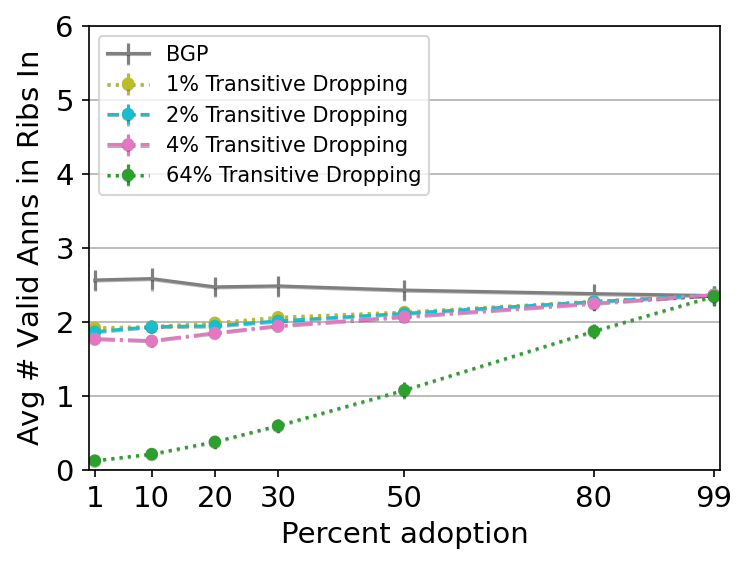

In [380]:
### Path End Comparison Scaled ###

#paths = [f'/home/cam/notebooks/tmp26/ezgraphs{i}/results.json' for i in range(60)]
paths = [f'/home/cam/notebooks/tmp33/ezgraphs{i}/results.json' for i in range(60)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

key = "ribs_in_valid_adopting"
result = PolicyResult("ribs_in_valid_non_adopting", "1", "TransitiveDroppingAS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping1AS", json_data)
#result2 = PolicyResult("disconnected_all", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result3 = PolicyResult(key, "0", "TransitiveDroppingAS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping1AS", json_data)
result4 = PolicyResult(key, "0", "TransitiveDropping2AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping2AS", json_data)
result5 = PolicyResult(key, "0", "TransitiveDropping4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping4AS", json_data) # yes this typo is correct
result5 = PolicyResult(key, "0", "TransitiveDropping4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping4AS", json_data) # yes this typo is correct
result6 = PolicyResult(key, "0", "TransitiveDropping64AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDropping64AS", json_data) # yes this typo is correct


l: Line = Line("BGP", False, result.non_adopting["ribs_in_valid_non_adopting"])
l1 = deepcopy(l)
#l2: Line = Line("No Transitive Dropping", False, result2.non_adopting["disconnected_all"])
l3: Line = Line("1% Transitive Dropping", False, result3.non_adopting[key])
l4: Line = Line("2% Transitive Dropping", False, result4.non_adopting[key])
l5: Line = Line("4% Transitive Dropping", False, result5.non_adopting[key])
l6: Line = Line("64% Transitive Dropping", False, result6.non_adopting[key])


#scale_line(l, l1)
#scale_line(l, l2)
#scale_line(l, l3)
#scale_line(l, l4)
#scale_line(l, l5)


generate_plot([l1, l3, l4, l5, l6], ylim=6, outcome_text="Avg $\#$ Valid Anns in Ribs In",
             size_inches=(5, 4),
             legend_kwargs={'loc':'upper left', 'prop':{'size': 10}},
             fname='/mnt/c/Users/cam/Pictures/transitive_dropping_graph.pgf')

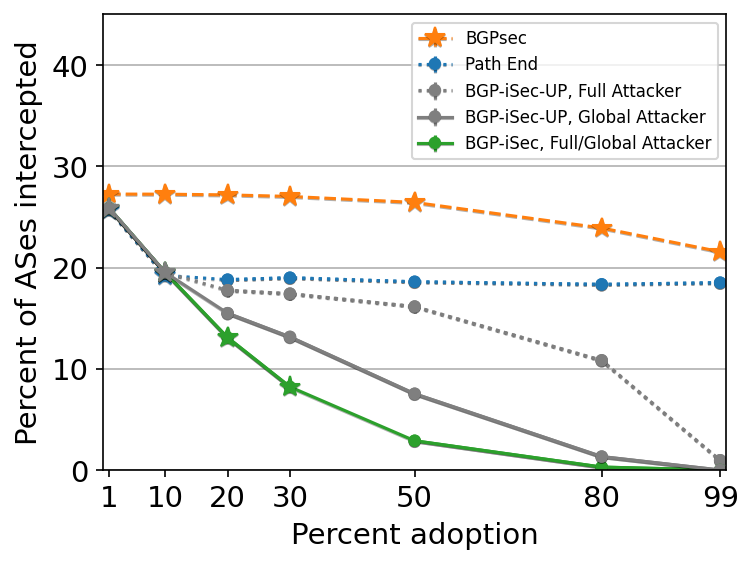

In [181]:
### Global Eavesdropper ###

#gen_adjusted_plot(rootdir, outcome, subgraph_sizes, order=[1, 2, 0, 3], size_inches=(5, 4), fname='/mnt/c/Users/cam/Pictures/timid_variants_graph.pgf',
#             drop_columns=['BGP', 'BGPsec Timid', 'BGPsec Aggressive', 'PaBGPsec Aggressive', 'PaBGPsec No Leak Prevention Aggressive', 'PaBGPsec No Path Shortening Defense Aggressive'],
#             text_replaces=[['PaBGPsec', 'BGP-Isec,'], ['BGPsec Aggressive', 'BGPsec'], ['BGP-Isec, No Leak Prevention', 'BGP-Isec-Trans-Path'], ['BGP-Isec, Timid Leak', 'BGP-Isec, Timid-All'], ['BGP-Isec, No Path Shortening Defense', 'BGP-Isec-Trans-DO,'], ['BGP-Isec-Trans-Path or Path Shortening', 'BGP-Isec-Trans,'], ['Timid', 'Timid-Path'], ['Timid-Path-All', 'Timid-All']],
#             legend_kwargs={'loc':'upper right', 'prop':{'size': 10}})


#paths = [f'/home/cam/notebooks/20230121/ezgraphs{i}/results.json' for i in range(100)]
#json_data = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data.append(json.load(json_file))
#        
#paths = [f'/home/cam/notebooks/tmp38/ezgraphs{i}/results.json' for i in range(100)]
#json_data2 = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data2.append(json.load(json_file))   
        
#paths = [f'/home/cam/notebooks/tmp44/ezgraphs{i}/results.json' for i in range(4)]
#json_data5 = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data5.append(json.load(json_file)) 
        
key = "attacker_success_all"
    
result = PolicyResult(key, "1", "BGP", "BaselineBGPAS", json_data)
resultl = PolicyResult(key, "1", "BGP", "BaselineBGPAS", json_data5)
result2 =  PolicyResult(key, "1", "BGP", "BGPsecAggressiveAS", json_data)
result3 = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result3a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data) # same aggressive results for ALL bgpisec variants
result4 = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyGlobalEavesdropperAS", json_data5)
result5 = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyEncrUpGlobalEavesdropperAS", json_data5)
result6 = PolicyResult(key, "1", "BGP", "PathEndTimidAS", json_data)
result6a = PolicyResult(key, "1", "BGP", "PathEndAggressiveAS", json_data)


lines = []
l: Line = Line("BGP", False, result.non_adopting[key])
ll: Line = Line("BGP", False, result.non_adopting[key])
lines.append(Line("BGPsec", False, result2.non_adopting[key])) # BGPsec, Restricted Eavesdropper
l6 = (Line("Path End", False, result6.non_adopting[key])) # Path End, No Eavesdropping (NOTE CHANGE)
l6a = (Line("Path End, Aggressive", False, result6a.non_adopting[key])) # Path End, Aggressive
l4 = (Line("BGP-iSec-UP, Full Attacker", False, result4.non_adopting[key])) # BGP-iSec, Eavesdropper
l3 = (Line("BGP-iSec-UP, Global Attacker", False, result3.non_adopting[key])) # BGP-iSec, No Eavesdropping
l3a = (Line("BGP-iSec-UP, Aggressive", False, result3a.non_adopting[key])) # BGP-iSec, Aggressive
l5a = (Line("BGP-iSec, Aggressive", False, result3a.non_adopting[key])) # BGP-iSec-EUp, Aggressive
l5 = (Line("BGP-iSec, Full Attacker", False, result5.non_adopting[key])) # BGP-iSec-E-UP, Eavesdropper

for line in lines:
    scale_line(l, line)
scale_line(l, l3a)
scale_line(ll, l3)
scale_line(l, l6a)
scale_line(l, l6)

lines += deepcopy(optimal_line('Path End', [l6a, l6])) # Path End, Restricted Eavesdropper
lines += deepcopy(optimal_line('BGP-iSec-UP, Full Attacker', [l3a, l4])) # BGP-iSec, Full Eavesdropper
lines += deepcopy(optimal_line('BGP-iSec, Full/Global Attacker', [l5a, l5])) # BGP-iSec-EUp, Full Eavesdropper
lines += deepcopy(optimal_line('BGP-iSec-UP, Global Attacker', [l3a, l3])) # BGP-iSec, Restricted Eavesdropper

generate_plot(lines, ylim=45, outcome_text="Percent of ASes intercepted",
             size_inches=(5, 4),
             order=(0, 1, 3, 8, 5),
             textwidth=60,
             legend_kwargs={'loc':'upper right', 'prop':{'size': 8}},
             fname='/mnt/c/Users/cam/Pictures/global_eavesdropper_graph.pgf')

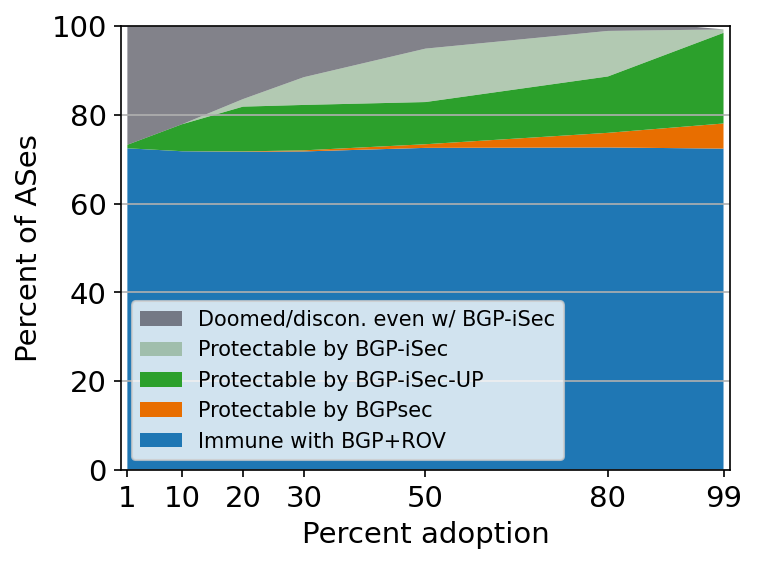

In [255]:
### OPTIMAL VARIANTS STACK PLOT ###


#paths = [f'/home/cam/notebooks/20230121/ezgraphs{i}/results.json' for i in range(100)]
#json_data = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data.append(json.load(json_file))

key = "victim_success_all"
result = PolicyResult(key, "1", "BGP", "BaselineBGPAS", json_data)
result2 = PolicyResult(key, "1", "BGP", "BGPsecAggressiveAS", json_data)
result3a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
#result3b = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result4a = PolicyResult('disconnected_all', "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result4b = PolicyResult('disconnected_all', "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result5a = PolicyResult('attacker_success_all', "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result5b = PolicyResult('attacker_success_all', "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result6 = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyEncrUpGlobalEavesdropperAS", json_data5)
result3b = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyUpGlobalEavesdropperAS", json_data7)


lines = []
l: Line = Line("BGP", False, result.non_adopting[key])
lines.append(deepcopy(l))
lines.append(Line("BGPsec", False, result2.non_adopting[key]))
l3a: Line = Line("BGP-iSec, Aggressive", False, result3a.non_adopting[key])
l3b: Line = Line("BGP-iSec", False, result3b.non_adopting[key])
l4a: Line = Line("BGP-iSec, Aggressive", False, result3a.non_adopting[key])
l4b: Line = Line("BGP-iSec", False, result6.non_adopting[key])
l5a: Line = Line("BGP-iSec, Aggressive", False, result5a.non_adopting['attacker_success_all'])
l5b: Line = Line("BGP-iSec", False, result5b.non_adopting['attacker_success_all'])

#lines += deepcopy(optimal_line('BGP-iSec, Full Attacker', [l3a, l5])) # BGP-iSec-EUp, Full Eavesdropper


lines.append(deepcopy(optimal_line("BGP-iSec-Trans-DO only, Connector", [l3a, l3b], invert=True)[0]))
lines.append(deepcopy(optimal_line('BGP-iSec, Connector', [l4a, l4b], invert=True)[0])) # inverted because 
lines.append(deepcopy(optimal_line("BGP-iSec with Path Shortening Defense, Connector", [l5a, l5b])[0]))

#for line in lines:
#    scale_line(l, line)

subtract_line(lines[-2], lines[-3])

"""The stack plot consists of:
    - bgp victim success (immune)
    - bgpsec victim success - bgp victim success (protectable)
    - bgpisec victim success - bgp victim success (protectable)
    - disconnections (disconnected by bgpisec)
    - attacker success bgpisec (doomed)"""
generate_stack_plot(lines, ylim=100, outcome_text="Percent of ASes",
             size_inches=(5, 4),
             order=(4, 3, 2, 1, 0),
             legend_kwargs={'loc':'lower left', 'prop':{'size': 10}}, 
             textwidth=33,
             fname='/mnt/c/Users/cam/Pictures/optimal_variants_stack_graph_all.pgf')


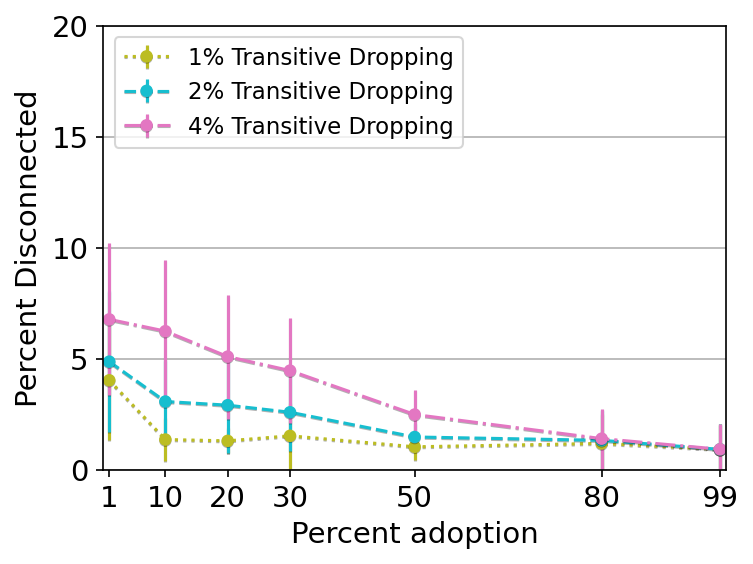

In [98]:
### Path End Comparison Scaled ###

#paths = [f'/home/cam/notebooks/tmp26/ezgraphs{i}/results.json' for i in range(60)]
paths = [f'/home/cam/notebooks/tmp40/ezgraphs{i}/results.json' for i in range(100)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

#result = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "BGP", "BaselineBGPAS", json_data)
#result2 = PolicyResult("disconnected_all", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result3 = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "TransitiveDroppingNoAdoptCustomersAS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers1AS", json_data)
result4 = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "TransitiveDroppingNoAdoptCustomers2AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers2AS", json_data)
result5 = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "TransitiveDroppingNoAdoptCustomers4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers4AS", json_data) # yes this typo is correct

subgraph_sizes = {
    'etc': 11330,
    'input_clique': 19,
    'mh': 35464,
    'stubs': 26430,
}


#l: Line = Line("BGP", False, result.non_adopting["disconnected_non_adopting_stubs_and_multihomed"])
#l1 = deepcopy(l)
#l2: Line = Line("No Transitive Dropping", False, result2.non_adopting["disconnected_all"])
l3: Line = Line("1% Transitive Dropping", False, result3.non_adopting["disconnected_adopting_stubs_and_multihomed"])
l4: Line = Line("2% Transitive Dropping", False, result4.non_adopting["disconnected_adopting_stubs_and_multihomed"])
l5: Line = Line("4% Transitive Dropping", False, result5.non_adopting["disconnected_adopting_stubs_and_multihomed"])


#scale_line(l, l1)
#scale_line(l, l2)
#scale_line(l, l3)
#scale_line(l, l4)
#scale_line(l, l5)


generate_plot([l3, l4, l5], ylim=20, outcome_text="Percent Disconnected",
             size_inches=(5, 4),
             legend_kwargs={'loc':'upper left', 'prop':{'size': 11}},
             fname='/mnt/c/Users/cam/Pictures/transitive_dropping_graph_non_adopting.pgf')

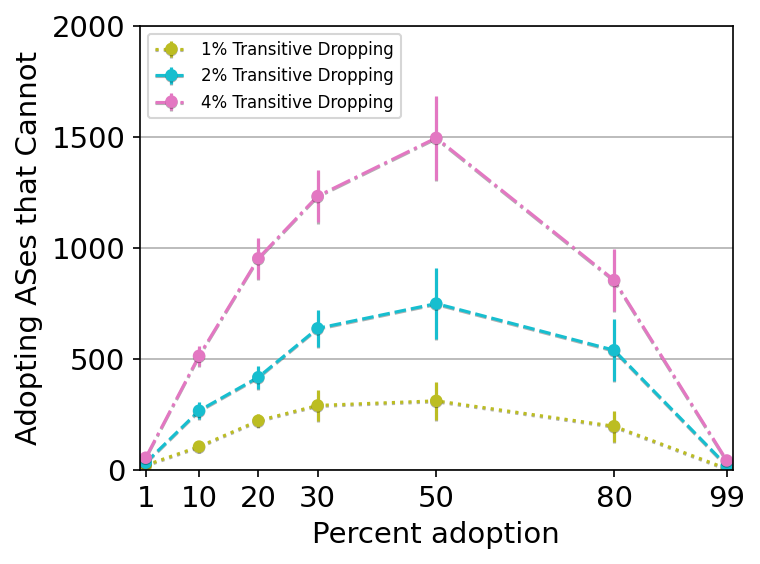

In [109]:
### Path End Comparison Scaled ###

#paths = [f'/home/cam/notebooks/tmp26/ezgraphs{i}/results.json' for i in range(60)]
paths = [f'/home/cam/notebooks/tmp40/ezgraphs{i}/results.json' for i in range(100)]
json_data = []
for path in paths:
    with open(path, "r") as json_file:
        json_data.append(json.load(json_file))

#result = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "BGP", "BaselineBGPAS", json_data)
#result2 = PolicyResult("disconnected_all", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result3 = PolicyResult("transitive_dropping_conversions_all", "0", "TransitiveDroppingNoAdoptCustomersAS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers1AS", json_data)
result4 = PolicyResult("transitive_dropping_conversions_all", "0", "TransitiveDroppingNoAdoptCustomers2AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers2AS", json_data)
result5 = PolicyResult("transitive_dropping_conversions_all", "0", "TransitiveDroppingNoAdoptCustomers4AS", "BGPsecTransitiveDownOnlyNoHashUpTimidTransitiveDroppingNoAdoptCustomers4AS", json_data) # yes this typo is correct

subgraph_sizes = {
    'etc': 11330,
    'input_clique': 19,
    'mh': 35464,
    'stubs': 26430,
}


#l: Line = Line("BGP", False, result.non_adopting["disconnected_non_adopting_stubs_and_multihomed"])
#l1 = deepcopy(l)
#l2: Line = Line("No Transitive Dropping", False, result2.non_adopting["disconnected_all"])
l3: Line = Line("1% Transitive Dropping", False, result3.non_adopting["transitive_dropping_conversions_all"])
l4: Line = Line("2% Transitive Dropping", False, result4.non_adopting["transitive_dropping_conversions_all"])
l5: Line = Line("4% Transitive Dropping", False, result5.non_adopting["transitive_dropping_conversions_all"])


#scale_line(l, l1)
#scale_line(l, l2)
#scale_line(l, l3)
#scale_line(l, l4)
#scale_line(l, l5)


generate_plot([l3, l4, l5], ylim=2000, outcome_text="Adopting ASes that Cannot",
             size_inches=(5, 4),
             legend_kwargs={'loc':'upper left', 'prop':{'size': 8}},
             fname='/mnt/c/Users/cam/Pictures/transitive_dropping_graph_non_adopting.pgf')

7
7


/home/cam/env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/cam/env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


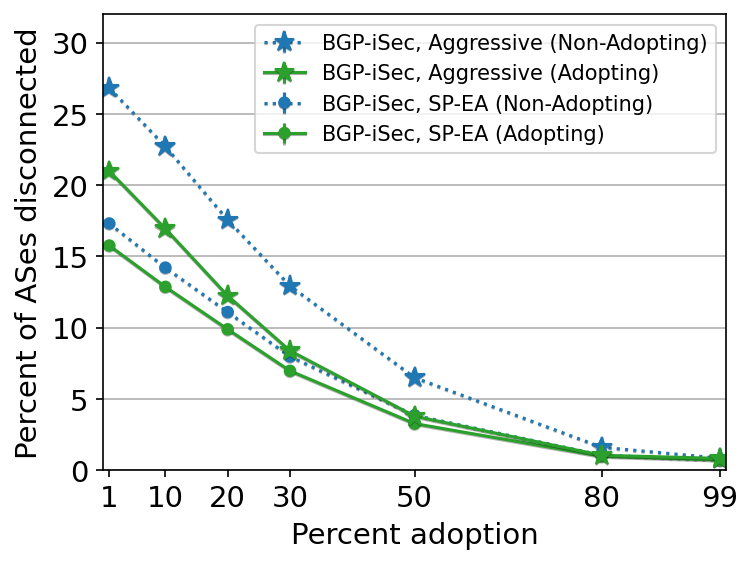

In [225]:
### Path End Comparison Scaled ###

#paths = [f'/home/cam/notebooks/tmp26/ezgraphs{i}/results.json' for i in range(60)]
#paths = [f'/home/cam/notebooks/20230121/ezgraphs{i}/results.json' for i in range(100)]
#json_data = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data.append(json.load(json_file))

#result = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "BGP", "BaselineBGPAS", json_data)
#result2 = PolicyResult("disconnected_all", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result3d = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "BGP", "BGPsecAggressiveAS", json_data)
result3a = PolicyResult("attacker_success_adopting_stubs_and_multihomed", "1", "BGP", "BGPsecAggressiveAS", json_data)
result4d = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result4a = PolicyResult("attacker_success_adopting_stubs_and_multihomed", "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result5d = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data) # yes this typo is correct
result5a = PolicyResult("attacker_success_adopting_stubs_and_multihomed", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data) # yes this typo is correct

result6a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyGlobalEavesdropperAS", json_data5)
result6d = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyGlobalEavesdropperAS", json_data5)

result7 = PolicyResult("disconnected_adopting_stubs_and_multihomed", "1", "BGP", "BGPsecTransitiveDownOnlyEncrUpGlobalEavesdropperAS", json_data5)

subgraph_sizes = {
    'etc': 11330,
    'input_clique': 19,
    'mh': 35464,
    'stubs': 26430,
}


#l: Line = Line("BGP", False, result.non_adopting["disconnected_non_adopting_stubs_and_multihomed"])
#l1 = deepcopy(l)
#l2: Line = Line("No Transitive Dropping", False, result2.non_adopting["disconnected_all"])
#l3d: Line = Line("BGPsec", False, result3d.non_adopting["disconnected_adopting_stubs_and_multihomed"])
#l3a: Line = Line("BGPsec", False, result3a.non_adopting["attacker_success_adopting_stubs_and_multihomed"])
#l3d.y = list(np.add(l3d.y, l3a.y))

l2d = get_combined_non_adopting_line("BGP-iSec, Aggressive (Non-Adopting)", "1", "BGPsecTransitiveDownOnlyAggressiveAS", json_data, outcome="disconnected")
l2a = get_combined_non_adopting_line("BGP-iSec, Aggressive (Non-Adopting)", "1", "BGPsecTransitiveDownOnlyAggressiveAS", json_data, outcome="attacker_success")
l2d.y = list(np.add(l2d.y, l2a.y))

l3d = get_combined_non_adopting_line("BGP-iSec, SP-EA (Non-Adopting)", "1", "BGPsecTransitiveDownOnlyEncrUpGlobalEavesdropperAS", json_data5, outcome="disconnected")
l3a = get_combined_non_adopting_line("BGP-iSec, SP-EA (Non-Adopting)", "1", "BGPsecTransitiveDownOnlyEncrUpGlobalEavesdropperAS", json_data5, outcome="attacker_success")
l3d.y = list(np.add(l3d.y, l3a.y))

#l4d: Line = Line("BGP-iSec, Aggressive", False, result4d.non_adopting["disconnected_adopting_stubs_and_multihomed"])
#l4a: Line = Line("BGP-iSec, Aggressive", False, result4a.non_adopting["attacker_success_adopting_stubs_and_multihomed"])
l4d = get_combined_adopting_line("BGP-iSec, Aggressive (Adopting)", "1", "BGPsecTransitiveDownOnlyAggressiveAS", json_data, outcome="disconnected")
l4a = get_combined_adopting_line("BGP-iSec, Aggressive (Adopting)", "1", "BGPsecTransitiveDownOnlyAggressiveAS", json_data, outcome="attacker_success")
l4d.y = list(np.add(l4d.y, l4a.y))
#l4d.y[-1] = -1

#l5d: Line = Line("BGP-iSec, Timid", False, result5d.non_adopting["disconnected_adopting_stubs_and_multihomed"])
#l5a: Line = Line("BGP-iSec, Timid", False, result5a.non_adopting["attacker_success_adopting_stubs_and_multihomed"])
l5d = get_combined_adopting_line("BGP-iSec, SP-EA (Adopting)", "1", "BGPsecTransitiveDownOnlyEncrUpGlobalEavesdropperAS", json_data5, outcome="disconnected")
l5a = get_combined_adopting_line("BGP-iSec, SP-EA (Adopting)", "1", "BGPsecTransitiveDownOnlyEncrUpGlobalEavesdropperAS", json_data5, outcome="attacker_success")
l5d.y = list(np.add(l5d.y, l5a.y))

l6 = deepcopy(l5d)
l6.label = "BGP-iSec"
#l6.y[0] = l4d.y[0]
#l4d.y = l4d.y[:1] + [np.NaN]*6
#l4d.x = l4d.x[1:]# + [np.NaN]*5
l4d.yerr = l4d.yerr[:1] + [np.NaN]*6
print(len(l4d.y))
print(len(l4d.x))

#scale_line(l, l1)
#scale_line(l, l2)
#scale_line(l, l3)
#scale_line(l, l4)
#scale_line(l, l5)



l1d = get_combined_adopting_line("BGPsec", "1", "BGPsecAggressiveAS", json_data, outcome="disconnected")
l1a = get_combined_adopting_line("BGPsec", "1", "BGPsecAggressiveAS", json_data, outcome="attacker_success")
l1d.y = list(np.add(l1d.y, l1a.y))



generate_plot([l3d, l2d, l5d, l4d], ylim=32, outcome_text="Percent of ASes disconnected",
             size_inches=(5, 4),
             order=[1, 3, 0, 2],
             textwidth=35,
             legend_kwargs={'loc':'upper right', 'prop':{'size': 10}},
             fname='/mnt/c/Users/cam/Pictures/dos_attacker_adopting.pgf')

7
7


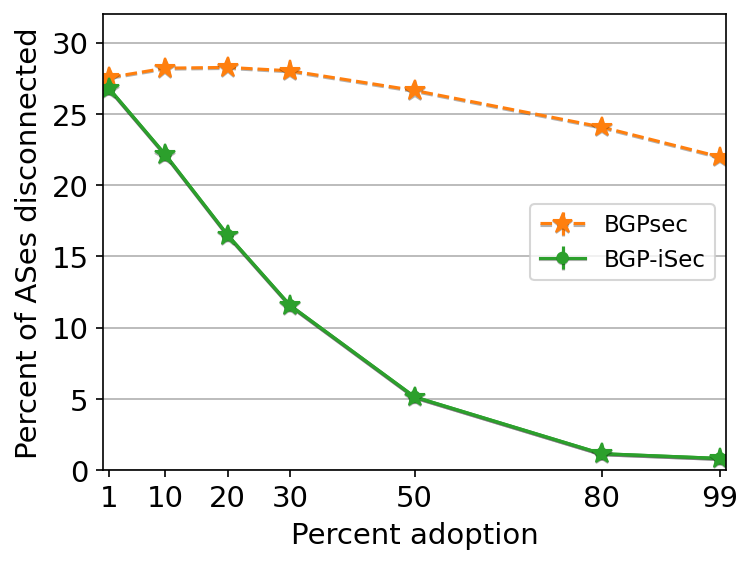

In [222]:
### Path End Comparison Scaled ###

#paths = [f'/home/cam/notebooks/tmp26/ezgraphs{i}/results.json' for i in range(60)]
#paths = [f'/home/cam/notebooks/20230121/ezgraphs{i}/results.json' for i in range(100)]
#json_data = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data.append(json.load(json_file))

#result = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "BGP", "BaselineBGPAS", json_data)
#result2 = PolicyResult("disconnected_all", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data)
result3d = PolicyResult("disconnected_all", "0", "BGP", "BGPsecAggressiveAS", json_data)
result3a = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecAggressiveAS", json_data)
result4d = PolicyResult("disconnected_all", "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result4a = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyAggressiveAS", json_data)
result5d = PolicyResult("disconnected_adopting_stubs_and_multihomed", "0", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data) # yes this typo is correct
result5a = PolicyResult("attacker_success_adopting_stubs_and_multihomed", "1", "BGP", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data) # yes this typo is correct

result6a = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyGlobalEavesdropperAS", json_data5)
result6d = PolicyResult(key, "1", "BGP", "BGPsecTransitiveDownOnlyGlobalEavesdropperAS", json_data5)

result7d = PolicyResult("disconnected_all", "1", "BGP", "BGPsecTransitiveDownOnlyEncrUpGlobalEavesdropperAS", json_data5)
result7a = PolicyResult("attacker_success_all", "1", "BGP", "BGPsecTransitiveDownOnlyEncrUpGlobalEavesdropperAS", json_data5)

subgraph_sizes = {
    'etc': 11330,
    'input_clique': 19,
    'mh': 35464,
    'stubs': 26430,
}


#l: Line = Line("BGP", False, result.non_adopting["disconnected_non_adopting_stubs_and_multihomed"])
#l1 = deepcopy(l)
#l2: Line = Line("No Transitive Dropping", False, result2.non_adopting["disconnected_all"])
l3d: Line = Line("BGPsec", False, result3d.non_adopting["disconnected_all"])
l3a: Line = Line("BGPsec", False, result3a.non_adopting["attacker_success_all"])
l3d.y = list(np.add(l3d.y, l3a.y))

l4d: Line = Line("BGP-iSec, Aggressive", False, result4d.non_adopting["disconnected_all"])
l4a: Line = Line("BGP-iSec, Aggressive", False, result4a.non_adopting["attacker_success_all"])
#l4d = get_combined_adopting_line("BGP-iSec, Aggressive", "1", "BGPsecTransitiveDownOnlyAggressiveAS", json_data, outcome="disconnected")
#l4a = get_combined_adopting_line("BGP-iSec, Aggressive", "1", "BGPsecTransitiveDownOnlyAggressiveAS", json_data, outcome="attacker_success")
l4d.y = list(np.add(l4d.y, l4a.y))
#l4d.y[-1] = -1

l5d: Line = Line("BGP-iSec", False, result7d.non_adopting["disconnected_all"])
l5a: Line = Line("BGP-iSec", False, result7a.non_adopting["attacker_success_all"])
#l5d = get_combined_adopting_line("BGP-iSec, Timid", "1", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data, outcome="disconnected")
#l5a = get_combined_adopting_line("BGP-iSec, Timid", "1", "BGPsecTransitiveDownOnlyNoHashUpTimidAS", json_data, outcome="attacker_success")
l5d.y = list(np.add(l5d.y, l5a.y))

l6 = deepcopy(l4d)
l6.label = "BGP-iSec"
#l6.y[0] = l4d.y[0]
#l4d.y = l4d.y[:1] + [np.NaN]*6
#l4d.x = l4d.x[1:]# + [np.NaN]*5
#l4d.yerr = l4d.yerr[:1] + [np.NaN]*6
print(len(l4d.y))
print(len(l4d.x))

#scale_line(l, l1)
#scale_line(l, l2)
#scale_line(l, l3)
#scale_line(l, l4)
#scale_line(l, l5)



l1d = get_combined_adopting_line("BGPsec", "1", "BGPsecAggressiveAS", json_data, outcome="disconnected")
l1a = get_combined_adopting_line("BGPsec", "1", "BGPsecAggressiveAS", json_data, outcome="attacker_success")
l1d.y = list(np.add(l1d.y, l1a.y))



generate_plot([l3d, l6, l4d], ylim=32, outcome_text="Percent of ASes disconnected",
             size_inches=(5, 4),
             order=[0, 1],
             legend_kwargs={'loc':'center right', 'prop':{'size': 11}},
             fname='/mnt/c/Users/cam/Pictures/dos_attacker.pgf')

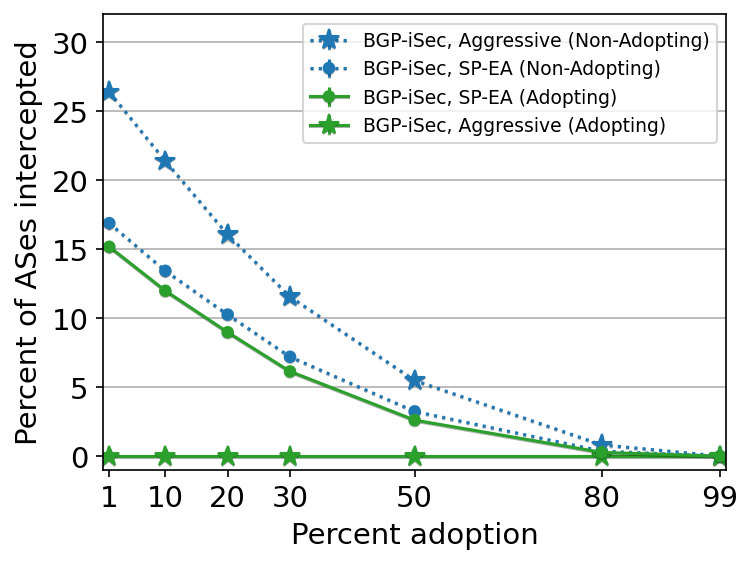

In [194]:
### Adopting Non Adopting ###

#gen_adjusted_plot(rootdir, outcome, subgraph_sizes, order=[1, 2, 0, 3], size_inches=(5, 4), fname='/mnt/c/Users/cam/Pictures/timid_variants_graph.pgf',
#             drop_columns=['BGP', 'BGPsec Timid', 'BGPsec Aggressive', 'PaBGPsec Aggressive', 'PaBGPsec No Leak Prevention Aggressive', 'PaBGPsec No Path Shortening Defense Aggressive'],
#             text_replaces=[['PaBGPsec', 'BGP-Isec,'], ['BGPsec Aggressive', 'BGPsec'], ['BGP-Isec, No Leak Prevention', 'BGP-Isec-Trans-Path'], ['BGP-Isec, Timid Leak', 'BGP-Isec, Timid-All'], ['BGP-Isec, No Path Shortening Defense', 'BGP-Isec-Trans-DO,'], ['BGP-Isec-Trans-Path or Path Shortening', 'BGP-Isec-Trans,'], ['Timid', 'Timid-Path'], ['Timid-Path-All', 'Timid-All']],
#             legend_kwargs={'loc':'upper right', 'prop':{'size': 10}})


#paths = [f'/home/cam/notebooks/20230121/ezgraphs{i}/results.json' for i in range(100)]
#json_data = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data.append(json.load(json_file))
#        
#paths = [f'/home/cam/notebooks/tmp38/ezgraphs{i}/results.json' for i in range(100)]
#json_data2 = []
#for path in paths:
#    with open(path, "r") as json_file:
#        json_data2.append(json.load(json_file))   

lines = []

lines.append(get_combined_non_adopting_line("BGP-iSec, Aggressive (Non-Adopting)", "1", "BGPsecTransitiveDownOnlyAggressiveAS", json_data))
lines.append(get_combined_non_adopting_line("BGP-iSec, SP-EA (Non-Adopting)", "1", "BGPsecTransitiveDownOnlyEncrUpGlobalEavesdropperAS", json_data5))
lines.append(get_combined_adopting_line("BGP-iSec, Aggressive (Adopting)", "1", "BGPsecTransitiveDownOnlyAggressiveAS", json_data))
lines.append(get_combined_adopting_line("BGP-iSec, SP-EA (Adopting)", "1", "BGPsecTransitiveDownOnlyEncrUpGlobalEavesdropperAS", json_data5))

for line in lines:
    scale_line(l, line)

generate_plot(lines, ymin=-1, ylim=32, outcome_text="Percent of ASes intercepted",
             size_inches=(5, 4),
             order=(0, 1, 3, 2),
             textwidth=60,
             legend_kwargs={'loc':'upper right', 'prop':{'size': 9}},
             fname='/mnt/c/Users/cam/Pictures/adopt_non_adopt.pgf')